# 🌍 Forecasting PM2.5 Air Pollution in Quito Using Time Series Analysis and Machine Learning

**Inteligencia Artificial II — Proyecto Final (Progreso 3)**

| | |
|---|---|
| **Autores** | Diego Toscano & Andrés Guamán |
| **Universidad** | Universidad de las Américas (UDLA) |
| **Fecha** | Febrero 2026 |
| **Dataset** | REMMAQ 2004–2025 (Secretaría de Ambiente, Municipio de Quito) |

---


## 1. Business Question Definition (10%)

### 1.1 Problem Statement

> **¿Cómo podemos pronosticar los niveles de PM2.5 (material particulado fino < 2.5 µm) en Quito para apoyar la planificación municipal y la protección de la salud ciudadana?**

PM2.5 es el contaminante atmosférico más peligroso monitoreado por la REMMAQ, ya que penetra profundamente en los pulmones y el sistema cardiovascular. Quito, ubicada a 2,850 m.s.n.m. en un valle rodeado de montañas, enfrenta condiciones geográficas que favorecen la concentración de contaminantes.

### 1.2 Stakeholders

| Stakeholder | Necesidad | Horizonte de Predicción |
|---|---|---|
| **Municipio de Quito / Secretaría de Ambiente** | Planificación de políticas de calidad del aire a largo plazo | Mensual, 5–10 años |
| **Ciudadanos** | Decisiones diarias (actividad al aire libre, uso de mascarilla) | Horario, 10 días |
| **Ministerio de Salud Pública** | Alertas epidemiológicas, asignación de recursos hospitalarios | Ambos horizontes |

### 1.3 Constraints & Challenges

- **Multi-source data**: 14 variables × 10 estaciones × 21 años de datos horarios
- **Missing values**: 18–32% de datos faltantes según variable/estación
- **Heterogeneidad**: Las estaciones no se activaron simultáneamente (ej. Guamaní y Centro tienen datos más tardíos)
- **Estacionalidad compleja**: Patrones diurnos, semanales, y anuales superpuestos
- **COVID-19**: Cambio estructural en las emisiones durante 2020 (reducción del 70% en contaminantes vehiculares)

### 1.4 Approach

Desarrollaremos un pipeline completo de análisis de datos siguiendo la metodología CRISP-DM:
1. Consolidación y preprocesamiento de datos multi-fuente
2. Análisis exploratorio con detección de changepoints (Prophet)
3. Feature engineering temporal y estático
4. Comparación de modelos: ARIMA(X), MLForecast (RF + XGBoost), LSTM
5. Despliegue interactivo via Streamlit


## Setup: Instalación de Dependencias e Importaciones

In [4]:
# ============================================================
# INSTALACIÓN DE DEPENDENCIAS
# ============================================================
!pip install -q pmdarima mlforecast prophet missingno pypots openpyxl xlrd scikit-learn xgboost lightgbm streamlit plotly nbformat     utilsforecast coreforecast window-ops

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import missingno as msno
from datetime import datetime, timedelta

# Sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# XGBoost
from xgboost import XGBRegressor

# Time Series specific
import pmdarima as pm
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# MLForecast
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

# Deep Learning (LSTM)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"   PyTorch: {torch.__version__} | CUDA available: {torch.cuda.is_available()}")
print(f"   Pandas: {pd.__version__} | NumPy: {np.__version__}")


✅ All libraries imported successfully!
   PyTorch: 2.9.0+cu126 | CUDA available: True
   Pandas: 2.2.2 | NumPy: 2.0.2


In [1]:
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Google Drive montado exitosamente! Puedes acceder a tus archivos en '/content/drive/MyDrive/'")

Mounted at /content/drive

✅ Google Drive montado exitosamente! Puedes acceder a tus archivos en '/content/drive/MyDrive/'


## 2. Data Collection and Preprocessing (20%)

### 2.1 Data Loading

Los datos provienen de la **REMMAQ** (Red Metropolitana de Monitoreo Atmosférico de Quito), operada por la Secretaría de Ambiente del Municipio de Quito desde 2004. Descargados desde: [datosambiente.quito.gob.ec](http://datosambiente.quito.gob.ec)

Cada archivo XLSX contiene datos horarios de una variable en su hoja `LIMPIO`, con columnas por estación de monitoreo.


In [6]:
# ============================================================
# 2.1 CARGA DE DATOS DESDE ARCHIVOS XLSX
# ============================================================
# Nota: Subir todos los archivos XLSX a Colab antes de ejecutar
# En Colab: usar el panel lateral Files para subir, o montar Google Drive

import os
from google.colab import files as colab_files

# Define file mapping: variable name -> (filename, is_accumulation)
FILE_MAP = {
    'co_mgm3':    ('CO.xlsx',   False),
    'no2_ugm3':   ('NO2.xlsx',  False),
    'o3_ugm3':    ('O3.xlsx',   False),
    'pm25_ugm3':  ('PM2_5.xlsx', False),
    'pm10_ugm3':  ('PM10.xlsx', False),
    'so2_ugm3':   ('SO2.xlsx',  False),
    'wind_direction_deg': ('DIR.xlsx', False),
    'humidity_pct':       ('HUM.xlsx', False),
    'uv_index':           ('IUV.xlsx', False),
    'precipitation_mm':   ('LLU.xlsx', True),   # ACCUMULATION → sum
    'pressure_hpa':       ('PRE.xlsx', False),
    'solar_radiation_wm2':('RS.xlsx',  False),
    'temperature_c':      ('TMP.xlsx', False),
    'wind_speed_ms':      ('VEL.xlsx', False),
}

# Station name standardization mapping
STATION_MAP = {
    'belisario': 'BELISARIO', 'carapungo': 'CARAPUNGO',
    'centro': 'CENTRO', 'cotocollao': 'COTOCOLLAO',
    'el camal': 'EL CAMAL', 'elcamal': 'EL CAMAL',
    'guamani': 'GUAMANI', 'guamaní': 'GUAMANI',
    'los chillos': 'LOS CHILLOS', 'loschillos': 'LOS CHILLOS',
    'san antonio': 'SAN ANTONIO', 'sanantonio': 'SAN ANTONIO',
    'tumbaco': 'TUMBACO', 'jipijapa': 'JIPIJAPA',
}

ALL_STATIONS = ['BELISARIO', 'CARAPUNGO', 'CENTRO', 'COTOCOLLAO',
                'EL CAMAL', 'GUAMANI', 'LOS CHILLOS', 'SAN ANTONIO', 'TUMBACO']

def standardize_station(name):
    """Standardize station names to uppercase format."""
    key = str(name).strip().lower().replace('_', ' ')
    return STATION_MAP.get(key, name.upper().strip())

def load_variable(filepath, var_name):
    """Load a single variable XLSX file and return long-format DataFrame."""
    try:
        xl = pd.ExcelFile(filepath)
        sheet = 'LIMPIO' if 'LIMPIO' in xl.sheet_names else xl.sheet_names[-1]
        df = pd.read_excel(xl, sheet_name=sheet)
    except Exception as e:
        try:
            xl = pd.ExcelFile(filepath, engine='xlrd')
            sheet = 'LIMPIO' if 'LIMPIO' in xl.sheet_names else xl.sheet_names[-1]
            df = pd.read_excel(xl, sheet_name=sheet, engine='xlrd')
        except Exception as e:
            print(f"  ⚠️  Error loading {filepath}: {e}")
            return pd.DataFrame()

    # Handle IUV special case (has header row in data)
    if var_name == 'uv_index' and df.iloc[0, 0] == 'FECHA':
        df = df.iloc[1:].reset_index(drop=True)
        df.columns = ['FECHA', 'JIPIJAPA']

    # Identify date column
    date_col = [c for c in df.columns if str(c).lower().startswith(('fecha', 'unnamed'))][0]
    df.rename(columns={date_col: 'datetime'}, inplace=True)
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df.dropna(subset=['datetime'], inplace=True)

    # Standardize station columns
    station_cols = [c for c in df.columns if c != 'datetime']
    rename_map = {c: standardize_station(c) for c in station_cols}
    df.rename(columns=rename_map, inplace=True)

    # Melt to long format
    station_cols_new = [c for c in df.columns if c != 'datetime']
    df_long = df.melt(id_vars='datetime', value_vars=station_cols_new,
                       var_name='station', value_name=var_name)
    df_long[var_name] = pd.to_numeric(df_long[var_name], errors='coerce')
    return df_long

# --- Load all files ---
print("📂 Loading REMMAQ data files...")
data_frames = {}
# data_dir = './'  # Change if files are in a subfolder

# --- Determine data directory ---
# Prioritize Google Drive path if it exists
drive_data_path = '/content/drive/MyDrive/Datos_IA_II'
if os.path.exists(drive_data_path):
    data_dir = drive_data_path
    print(f"✅ Archivos serán cargados desde Google Drive: {data_dir}")
else:
    data_dir = '.' # Fallback to current Colab environment
    print(f"✅ Archivos serán cargados desde el entorno local de Colab: {data_dir}")

for var_name, (filename, _) in FILE_MAP.items():
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        df = load_variable(filepath, var_name)
        if not df.empty:
            data_frames[var_name] = df
            n_stations = df['station'].nunique()
            date_range = f"{df['datetime'].min().strftime('%Y-%m-%d')} → {df['datetime'].max().strftime('%Y-%m-%d')}"
            print(f"  ✅ {var_name:25s} | {n_stations} stations | {len(df):>10,} rows | {date_range}")
    else:
        print(f"  ❌ {filename} not found — skipping {var_name}")

print(f"\n✅ Loaded {len(data_frames)} of {len(FILE_MAP)} variables")


📂 Loading REMMAQ data files...
✅ Archivos serán cargados desde Google Drive: /content/drive/MyDrive/Datos_IA_II
  ✅ co_mgm3                   | 8 stations |  1,540,168 rows | 2004-01-01 → 2025-12-31
  ✅ no2_ugm3                  | 8 stations |  1,541,384 rows | 2004-01-01 → 2025-12-31
  ✅ o3_ugm3                   | 9 stations |  1,734,093 rows | 2004-01-01 → 2025-12-31
  ✅ pm25_ugm3                 | 9 stations |  1,683,765 rows | 2004-08-26 → 2025-12-31
  ✅ pm10_ugm3                 | 3 stations |    326,406 rows | 2013-08-01 → 2025-12-31
  ✅ so2_ugm3                  | 8 stations |  1,540,472 rows | 2004-01-01 → 2025-12-31
  ✅ wind_direction_deg        | 9 stations |  1,735,425 rows | 2004-01-01 → 2025-12-31
  ✅ humidity_pct              | 9 stations |  1,735,443 rows | 2004-01-01 → 2025-12-31
  ✅ uv_index                  | 1 stations |     73,315 rows | 2017-08-01 → 2025-12-31
  ✅ precipitation_mm          | 9 stations |  1,735,461 rows | 2004-01-01 → 2025-12-31
  ✅ pressure_hpa  

In [7]:
# ============================================================
# 2.2 CONSOLIDACIÓN EN DATASET UNIFICADO
# ============================================================
print("🔗 Merging all variables into unified dataset...")

# Start with the target variable
if 'pm25_ugm3' not in data_frames:
    raise FileNotFoundError("PM2_5.xlsx is required! Please upload it.")

df_unified = data_frames['pm25_ugm3'].copy()

# Merge all other variables
for var_name, df_var in data_frames.items():
    if var_name == 'pm25_ugm3':
        continue
    df_unified = df_unified.merge(
        df_var, on=['datetime', 'station'], how='outer'
    )

# Sort and set index
df_unified.sort_values(['station', 'datetime'], inplace=True)
df_unified.reset_index(drop=True, inplace=True)

# Filter to main 9 stations (exclude JIPIJAPA which only has UV)
df_unified = df_unified[df_unified['station'].isin(ALL_STATIONS)].copy()

print(f"\n📊 Unified Dataset Shape: {df_unified.shape}")
print(f"   Stations: {sorted(df_unified['station'].unique())}")
print(f"   Date range: {df_unified['datetime'].min()} → {df_unified['datetime'].max()}")
print(f"   Variables: {[c for c in df_unified.columns if c not in ['datetime','station']]}")
print(f"\n📈 Summary Statistics:")
display(df_unified.describe().round(2))


🔗 Merging all variables into unified dataset...

📊 Unified Dataset Shape: (1735770, 16)
   Stations: ['BELISARIO', 'CARAPUNGO', 'CENTRO', 'COTOCOLLAO', 'EL CAMAL', 'GUAMANI', 'LOS CHILLOS', 'SAN ANTONIO', 'TUMBACO']
   Date range: 2004-01-01 00:00:00 → 2025-12-31 23:00:00
   Variables: ['pm25_ugm3', 'co_mgm3', 'no2_ugm3', 'o3_ugm3', 'pm10_ugm3', 'so2_ugm3', 'wind_direction_deg', 'humidity_pct', 'uv_index', 'precipitation_mm', 'pressure_hpa', 'solar_radiation_wm2', 'temperature_c', 'wind_speed_ms']

📈 Summary Statistics:


,datetime,pm25_ugm3,co_mgm3,no2_ugm3,o3_ugm3,pm10_ugm3,so2_ugm3,wind_direction_deg,humidity_pct,uv_index,precipitation_mm,pressure_hpa,solar_radiation_wm2,temperature_c,wind_speed_ms
count,1735770,1151673.00,1174131.00,1143550.00,1418912.00,184544.00,1183530.00,1261815.00,1287647.00,0.00,1375217.00,1302758.00,1138051.00,1307345.00,1300633.00
mean,2014-12-31 23:11:52.259803648,16.58,0.74,23.22,25.23,47.21,4.59,159.75,72.00,NaN,0.12,741.83,212.25,14.79,1.60
min,2004-01-01 00:00:00,0.00,0.00,0.00,-14.13,-4.60,0.00,0.00,0.02,NaN,0.00,702.35,0.00,0.65,0.00
25%,2009-07-01 23:00:00,8.54,0.41,12.51,7.74,17.48,1.73,73.19,56.65,NaN,0.00,726.64,0.00,11.99,0.78
50%,2014-12-31 23:00:00,14.48,0.58,21.22,20.85,31.34,2.90,145.53,75.07,NaN,0.00,732.84,6.13,13.93,1.26
75%,2020-07-01 23:00:00,22.00,0.87,31.42,38.29,50.60,5.32,233.38,89.33,NaN,0.00,760.73,384.20,17.40,2.20
max,2025-12-31 23:00:00,875.30,7.00,123.98,178.19,99999.90,143.39,360.00,100.00,NaN,55.90,782.11,1333.78,28.85,10.08
std,NaN,11.39,0.57,13.71,20.70,959.82,5.34,102.93,19.41,NaN,0.89,19.31,307.41,3.63,1.13


### 2.3 Visualización de Datos Faltantes con `missingno`

Utilizamos la librería `missingno` para analizar la distribución y patrones de valores faltantes en el dataset. Esto es crucial para seleccionar la estrategia de imputación adecuada.


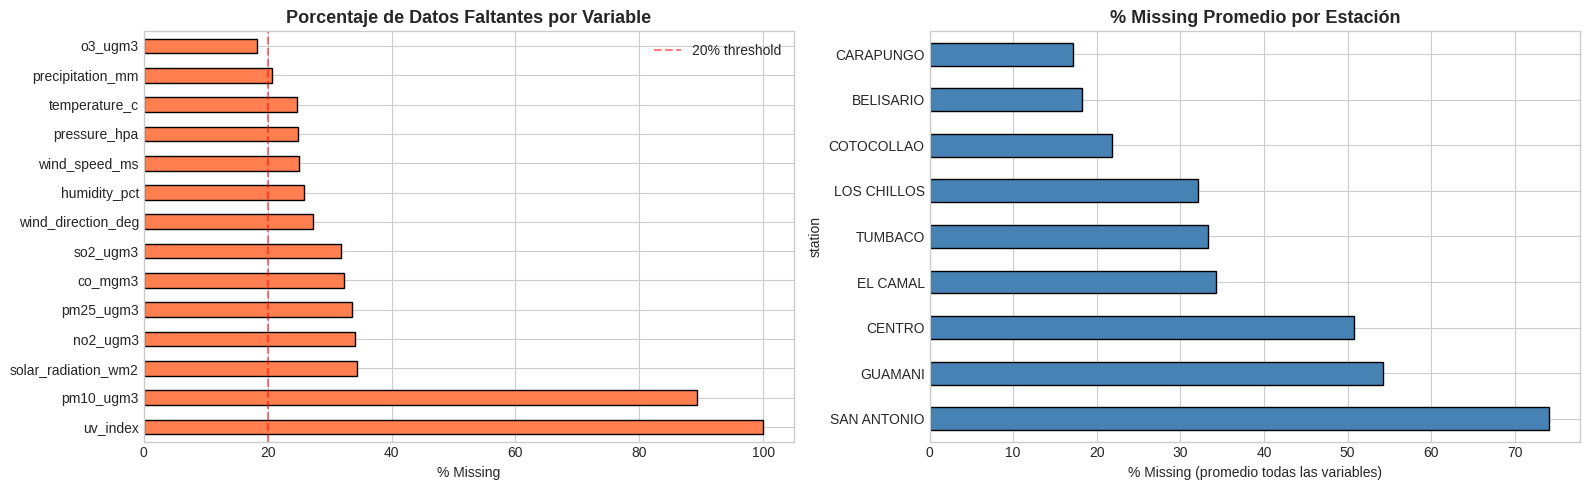


📊 Porcentaje de datos faltantes por variable:
   uv_index                 : 100.0%
   pm10_ugm3                : 89.4%
   solar_radiation_wm2      : 34.4%
   no2_ugm3                 : 34.1%
   pm25_ugm3                : 33.7%
   co_mgm3                  : 32.4%
   so2_ugm3                 : 31.8%
   wind_direction_deg       : 27.3%
   humidity_pct             : 25.8%
   wind_speed_ms            : 25.1%
   pressure_hpa             : 24.9%
   temperature_c            : 24.7%
   precipitation_mm         : 20.8%
   o3_ugm3                  : 18.3%


In [8]:
# ============================================================
# 2.3 VISUALIZACIÓN DE DATOS FALTANTES
# ============================================================

# --- Missing data summary per variable ---
numeric_cols = [c for c in df_unified.columns if c not in ['datetime', 'station']]
missing_summary = df_unified[numeric_cols].isnull().mean().sort_values(ascending=False) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Bar chart of missing percentages
missing_summary.plot(kind='barh', ax=axes[0], color='coral', edgecolor='black')
axes[0].set_title('Porcentaje de Datos Faltantes por Variable', fontsize=13, fontweight='bold')
axes[0].set_xlabel('% Missing')
axes[0].axvline(x=20, color='red', linestyle='--', alpha=0.5, label='20% threshold')
axes[0].legend()

# Missing per station
missing_by_station = df_unified.groupby('station')[numeric_cols].apply(
    lambda x: x.isnull().mean().mean() * 100
).sort_values(ascending=False)
missing_by_station.plot(kind='barh', ax=axes[1], color='steelblue', edgecolor='black')
axes[1].set_title('% Missing Promedio por Estación', fontsize=13, fontweight='bold')
axes[1].set_xlabel('% Missing (promedio todas las variables)')
plt.tight_layout()
plt.savefig('missing_data_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Porcentaje de datos faltantes por variable:")
for col, pct in missing_summary.items():
    print(f"   {col:25s}: {pct:.1f}%")


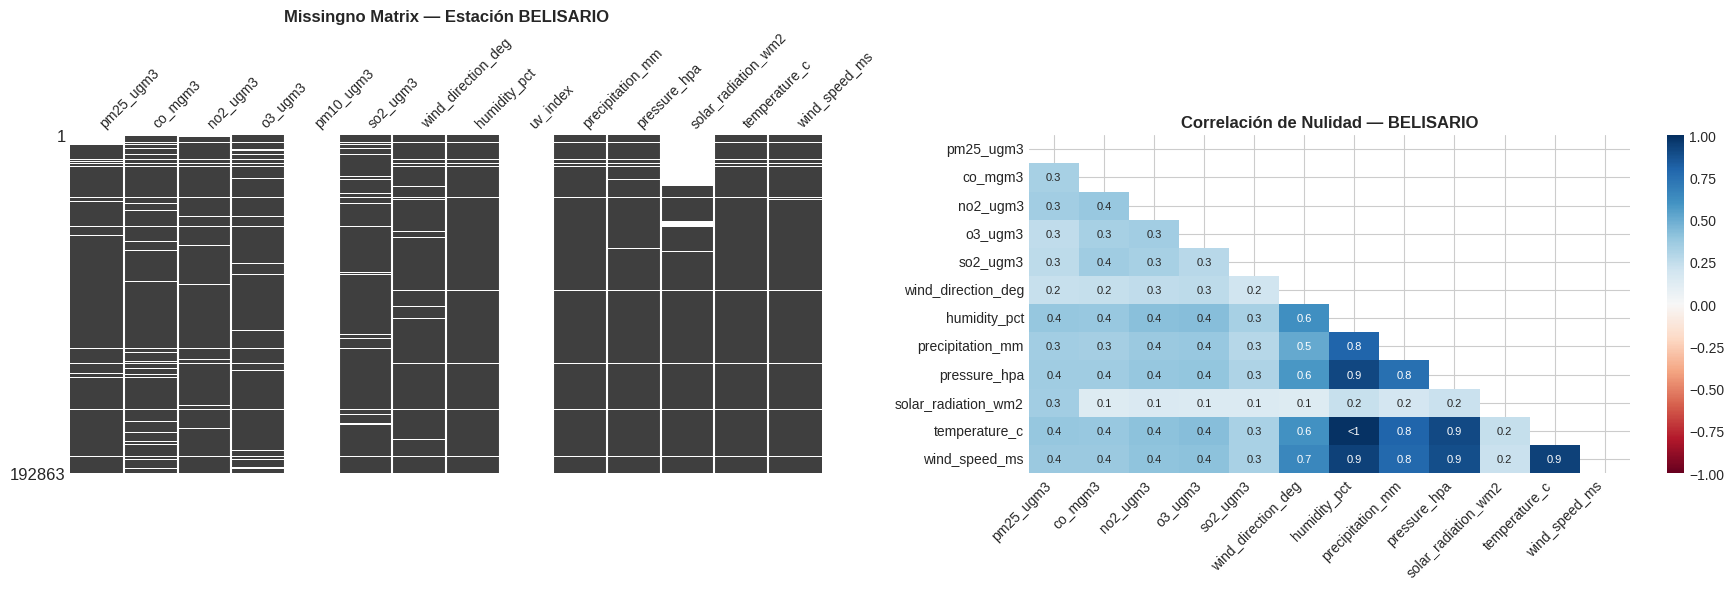

In [9]:
# --- Missingno Matrix for a sample station ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Matrix plot for BELISARIO
station_sample = df_unified[df_unified['station'] == 'BELISARIO'][numeric_cols].copy()
station_sample.index = df_unified[df_unified['station'] == 'BELISARIO']['datetime']

msno.matrix(station_sample, ax=axes[0], sparkline=True, fontsize=10)
axes[0].set_title('Missingno Matrix — Estación BELISARIO', fontsize=12, fontweight='bold')

# Correlation heatmap of missingness
msno.heatmap(station_sample, ax=axes[1], fontsize=10)
axes[1].set_title('Correlación de Nulidad — BELISARIO', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('missingno_analysis.png', dpi=150, bbox_inches='tight')
plt.show()


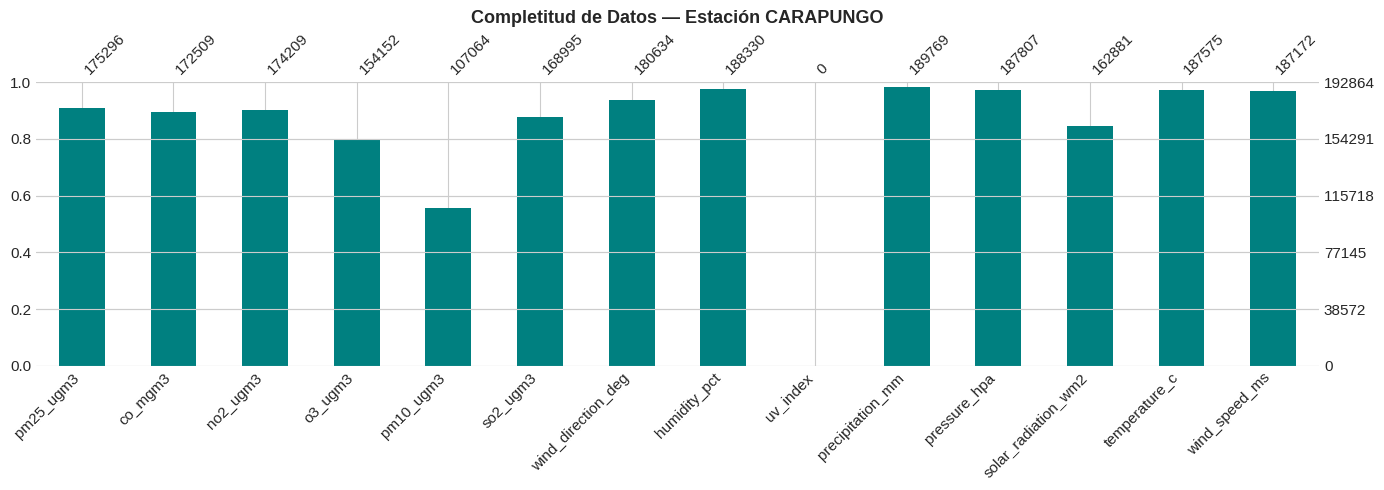

In [10]:
# --- Missingno Bar chart (all data) ---
fig, ax = plt.subplots(figsize=(14, 5))
sample_wide = df_unified[df_unified['station'] == 'CARAPUNGO'][numeric_cols]
msno.bar(sample_wide, ax=ax, fontsize=11, color='teal')
ax.set_title('Completitud de Datos — Estación CARAPUNGO', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('missingno_bar.png', dpi=150, bbox_inches='tight')
plt.show()


### 2.4 Imputación de Datos Faltantes

Aplicamos una estrategia de imputación en capas:
1. **Interpolación temporal** (linear) dentro de cada estación — captura la continuidad temporal natural
2. **Forward/Backward fill** para gaps residuales cortos
3. **Mediana por estación y hora** para gaps más largos
4. **KNN Imputer** de scikit-learn como respaldo final

> **Nota sobre SAITS**: Para datasets con patrones complejos de missing data, SAITS (Self-Attention-based Imputation for Time Series) de la librería PyPOTS ofrece imputación basada en deep learning. Lo utilizamos opcionalmente para las variables principales. Referencia: Du, W., Cote, D., & Liu, Y. (2023). *SAITS: Self-Attention-based Imputation for Time Series.* Expert Systems with Applications.


In [11]:
# ============================================================
# 2.4 IMPUTACIÓN DE DATOS FALTANTES
# ============================================================

def impute_station_data(group):
    """Multi-strategy imputation for a single station's data."""
    group = group.sort_values('datetime').copy()

    numeric_cols_local = [c for c in group.columns if c not in ['datetime', 'station']]

    for col in numeric_cols_local:
        # Step 1: Linear interpolation (up to 6 hour gaps)
        group[col] = group[col].interpolate(method='linear', limit=6)

        # Step 2: Forward/backward fill (up to 3 hours)
        group[col] = group[col].ffill(limit=3).bfill(limit=3)

    # Step 3: Fill remaining with hourly median per variable
    group['hour'] = group['datetime'].dt.hour
    group['month'] = group['datetime'].dt.month
    for col in numeric_cols_local:
        if group[col].isnull().any():
            # Fill with median of same hour & month
            fill_vals = group.groupby(['month', 'hour'])[col].transform('median')
            group[col] = group[col].fillna(fill_vals)
    group.drop(columns=['hour', 'month'], inplace=True)

    return group

print("🔧 Imputing missing values (multi-strategy)...")
print(f"   Before imputation: {df_unified[numeric_cols].isnull().sum().sum():,} total NaN values")

df_imputed = df_unified.groupby('station', group_keys=False).apply(impute_station_data)

# Final fallback: fill remaining with column median
for col in numeric_cols:
    remaining_na = df_imputed[col].isnull().sum()
    if remaining_na > 0:
        df_imputed[col].fillna(df_imputed[col].median(), inplace=True)

print(f"   After imputation:  {df_imputed[numeric_cols].isnull().sum().sum():,} total NaN values")
print("✅ Imputation complete!")

# Verify
display(df_imputed[numeric_cols].describe().round(2))


🔧 Imputing missing values (multi-strategy)...
   Before imputation: 9,070,974 total NaN values
   After imputation:  1,735,770 total NaN values
✅ Imputation complete!


,pm25_ugm3,co_mgm3,no2_ugm3,o3_ugm3,pm10_ugm3,so2_ugm3,wind_direction_deg,humidity_pct,uv_index,precipitation_mm,pressure_hpa,solar_radiation_wm2,temperature_c,wind_speed_ms
count,1735770.00,1735770.00,1735770.00,1735770.00,1735770.00,1735770.00,1735770.00,1735770.00,0.00,1735770.00,1735770.00,1735770.00,1735770.00,1735770.00
mean,15.62,0.68,21.52,24.72,27.91,4.22,153.88,72.39,NaN,0.10,739.68,212.11,14.66,1.58
std,9.91,0.51,12.12,19.91,313.08,4.77,95.87,18.71,NaN,0.80,20.44,300.04,3.50,1.04
min,0.00,0.00,0.00,-14.13,-4.60,0.00,0.00,0.02,NaN,0.00,702.35,0.00,0.65,0.00
25%,9.45,0.42,12.90,8.16,25.50,1.88,79.14,58.06,NaN,0.00,726.15,0.00,11.96,0.83
50%,13.79,0.55,19.42,20.14,25.50,2.84,138.96,74.89,NaN,0.00,730.54,6.86,13.80,1.27
75%,19.25,0.76,27.53,37.08,25.50,4.57,212.74,89.08,NaN,0.00,761.34,402.17,17.19,2.14
max,875.30,7.00,123.98,178.19,99999.90,143.39,360.00,100.00,NaN,55.90,782.11,1333.78,28.85,10.08


### 2.5 Resampling: Datos Mensuales y Horarios

Para los dos horizontes de predicción, necesitamos dos versiones del dataset:
- **Mensual**: Para pronóstico a 5–10 años (municipalidad). Precipitación se agrega por **suma**, el resto por **media**.
- **Horario**: Para pronóstico a 10 días (ciudadano). Se usa el dataset original sin resamplear.


In [12]:
# ============================================================
# 2.5 RESAMPLING
# ============================================================

# Identify accumulation vs mean variables
accum_vars = ['precipitation_mm']
mean_vars = [c for c in numeric_cols if c not in accum_vars]

# --- Monthly resampling ---
print("📅 Resampling to monthly frequency...")

def resample_station_monthly(group):
    group = group.set_index('datetime')
    agg_dict = {}
    for col in mean_vars:
        if col in group.columns:
            agg_dict[col] = 'mean'
    for col in accum_vars:
        if col in group.columns:
            agg_dict[col] = 'sum'
    return group.resample('MS').agg(agg_dict)

df_monthly = df_imputed.groupby('station', group_keys=True).apply(
    resample_station_monthly
).reset_index()

print(f"   Monthly dataset shape: {df_monthly.shape}")
print(f"   Date range: {df_monthly['datetime'].min()} → {df_monthly['datetime'].max()}")

# --- Hourly dataset (keep as-is, filter recent years for 10-day model) ---
df_hourly = df_imputed.copy()
print(f"\n🕐 Hourly dataset shape: {df_hourly.shape}")

# Save processed datasets
df_monthly.to_csv('data_monthly.csv', index=False)
df_hourly.to_csv('data_hourly.csv', index=False)
print("\n💾 Saved: data_monthly.csv, data_hourly.csv")


📅 Resampling to monthly frequency...
   Monthly dataset shape: (2376, 16)
   Date range: 2004-01-01 00:00:00 → 2025-12-01 00:00:00

🕐 Hourly dataset shape: (1735770, 16)

💾 Saved: data_monthly.csv, data_hourly.csv


## 3. Exploratory Data Analysis — EDA (15%)

### 3.1 Tendencias Temporales de PM2.5


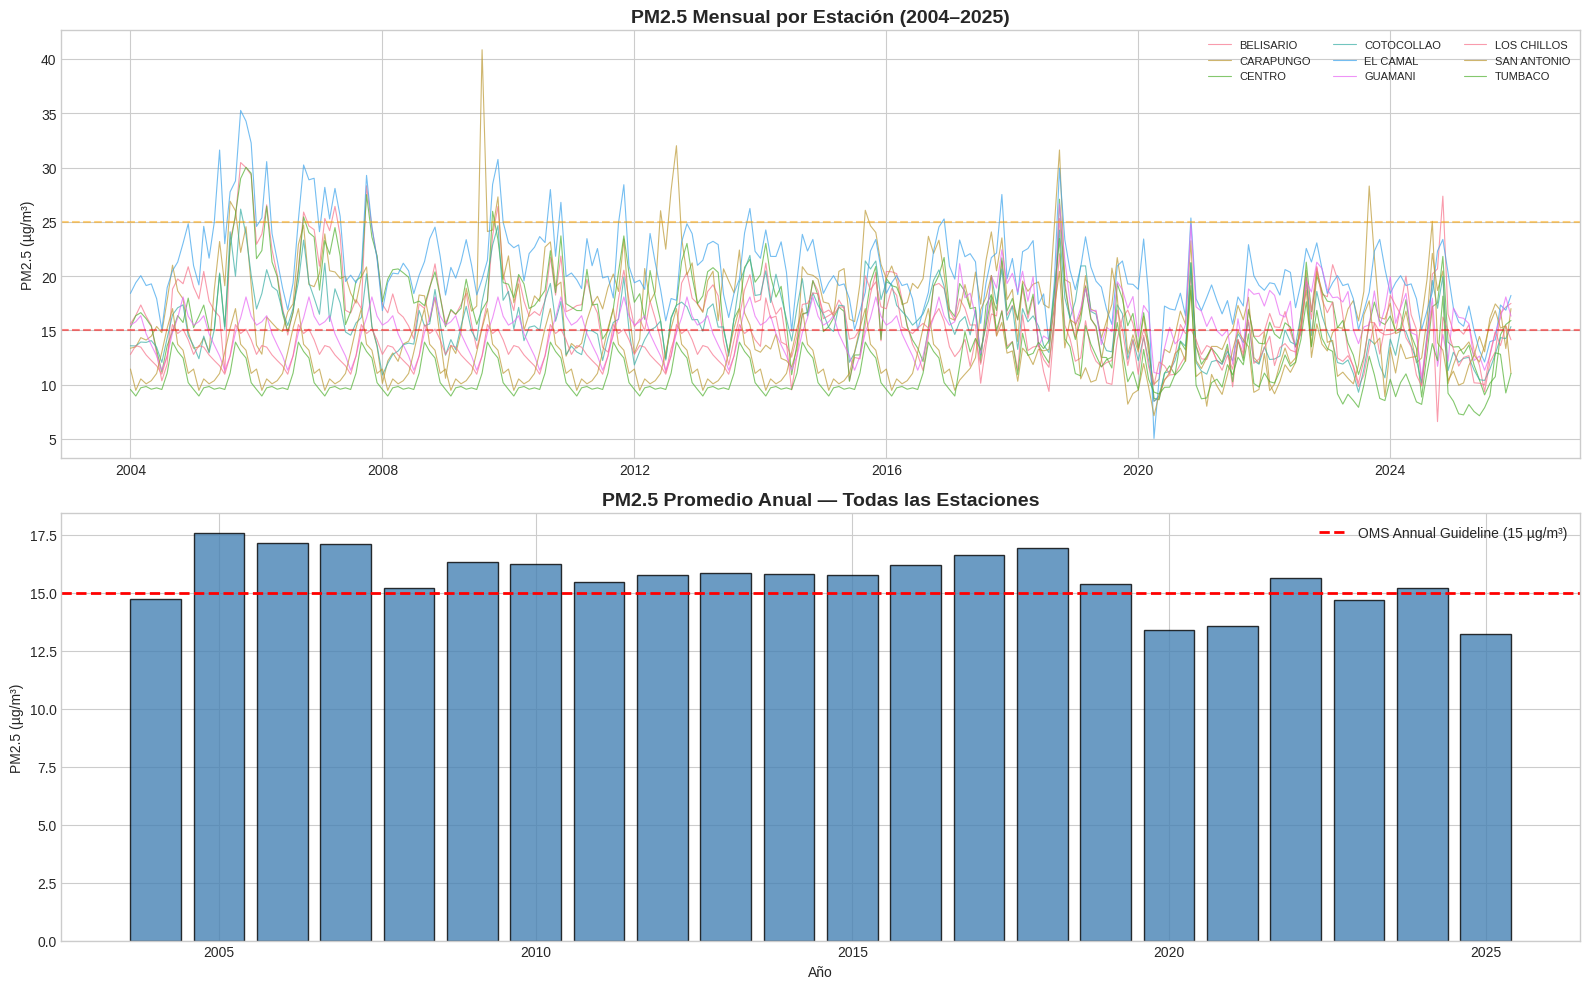

In [13]:
# ============================================================
# 3.1 TENDENCIAS TEMPORALES PM2.5
# ============================================================

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Monthly PM2.5 trend per station
for station in ALL_STATIONS:
    mask = df_monthly['station'] == station
    if 'pm25_ugm3' in df_monthly.columns and mask.any():
        data = df_monthly[mask].sort_values('datetime')
        axes[0].plot(data['datetime'], data['pm25_ugm3'], label=station, alpha=0.7, linewidth=0.8)

axes[0].set_title('PM2.5 Mensual por Estación (2004–2025)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].legend(loc='upper right', fontsize=8, ncol=3)
axes[0].axhline(y=15, color='red', linestyle='--', alpha=0.5, label='OMS Guía Anual (15 µg/m³)')
axes[0].axhline(y=25, color='orange', linestyle='--', alpha=0.5, label='NECAA 24h (50 µg/m³)')

# Annual average across all stations
annual = df_monthly.groupby(df_monthly['datetime'].dt.year)['pm25_ugm3'].mean()
axes[1].bar(annual.index, annual.values, color='steelblue', edgecolor='black', alpha=0.8)
axes[1].axhline(y=15, color='red', linestyle='--', linewidth=2, label='OMS Annual Guideline (15 µg/m³)')
axes[1].set_title('PM2.5 Promedio Anual — Todas las Estaciones', fontsize=14, fontweight='bold')
axes[1].set_ylabel('PM2.5 (µg/m³)')
axes[1].set_xlabel('Año')
axes[1].legend()

plt.tight_layout()
plt.savefig('pm25_trends.png', dpi=150, bbox_inches='tight')
plt.show()


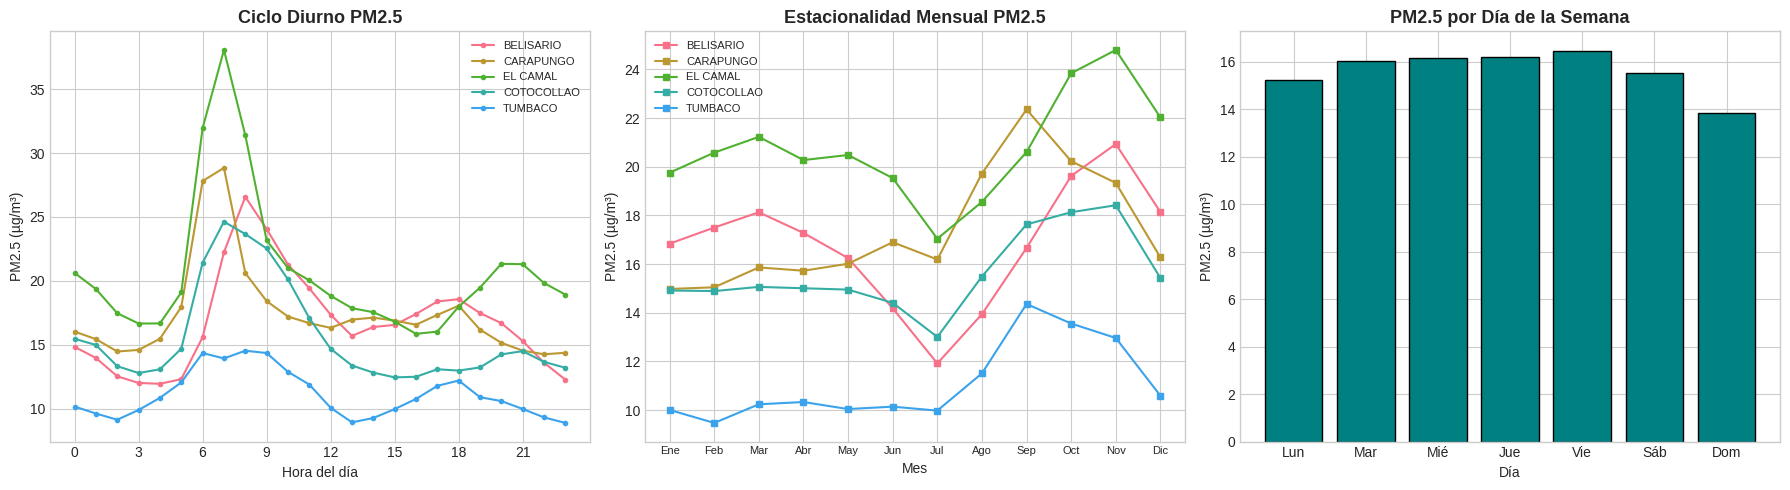

In [14]:
# ============================================================
# 3.2 PATRONES ESTACIONALES Y DIURNOS
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hourly pattern (diurnal cycle)
hourly_pattern = df_hourly.groupby([df_hourly['datetime'].dt.hour, 'station'])['pm25_ugm3'].mean().reset_index()
hourly_pattern.columns = ['hour', 'station', 'pm25']
for station in ['BELISARIO', 'CARAPUNGO', 'EL CAMAL', 'COTOCOLLAO', 'TUMBACO']:
    s_data = hourly_pattern[hourly_pattern['station'] == station]
    if not s_data.empty:
        axes[0].plot(s_data['hour'], s_data['pm25'], marker='o', markersize=3, label=station)
axes[0].set_title('Ciclo Diurno PM2.5', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Hora del día')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].legend(fontsize=8)
axes[0].set_xticks(range(0, 24, 3))

# Monthly seasonality
monthly_pattern = df_monthly.groupby([df_monthly['datetime'].dt.month, 'station'])['pm25_ugm3'].mean().reset_index()
monthly_pattern.columns = ['month', 'station', 'pm25']
for station in ['BELISARIO', 'CARAPUNGO', 'EL CAMAL', 'COTOCOLLAO', 'TUMBACO']:
    s_data = monthly_pattern[monthly_pattern['station'] == station]
    if not s_data.empty:
        axes[1].plot(s_data['month'], s_data['pm25'], marker='s', markersize=4, label=station)
axes[1].set_title('Estacionalidad Mensual PM2.5', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Mes')
axes[1].set_ylabel('PM2.5 (µg/m³)')
axes[1].legend(fontsize=8)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'], fontsize=8)

# Day of week pattern
dow_pattern = df_hourly.groupby([df_hourly['datetime'].dt.dayofweek])['pm25_ugm3'].mean()
day_names = ['Lun','Mar','Mié','Jue','Vie','Sáb','Dom']
axes[2].bar(range(7), dow_pattern.values, color='teal', edgecolor='black')
axes[2].set_title('PM2.5 por Día de la Semana', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Día')
axes[2].set_ylabel('PM2.5 (µg/m³)')
axes[2].set_xticks(range(7))
axes[2].set_xticklabels(day_names)

plt.tight_layout()
plt.savefig('pm25_seasonality.png', dpi=150, bbox_inches='tight')
plt.show()


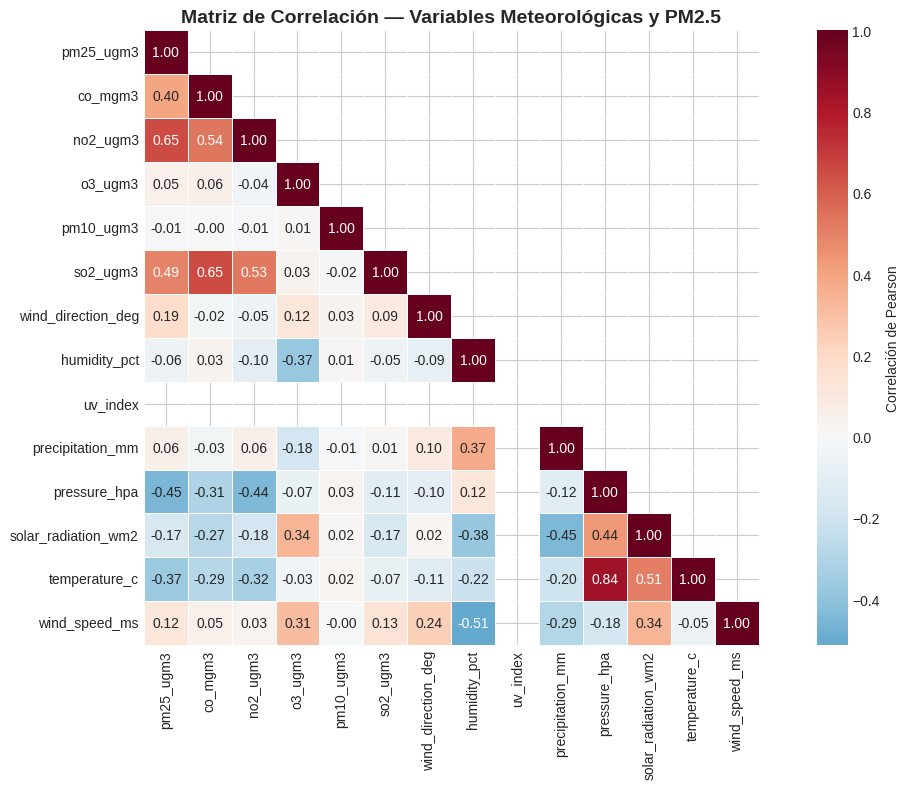


🔗 Top correlaciones con PM2.5:
   📈 no2_ugm3                 : +0.649
   📈 so2_ugm3                 : +0.493
   📉 pressure_hpa             : -0.453
   📈 co_mgm3                  : +0.396
   📉 temperature_c            : -0.366
   📈 wind_direction_deg       : +0.186
   📉 solar_radiation_wm2      : -0.168
   📈 wind_speed_ms            : +0.124
   📈 precipitation_mm         : +0.063
   📉 humidity_pct             : -0.063
   📈 o3_ugm3                  : +0.049
   📉 pm10_ugm3                : -0.005
   📉 uv_index                 : +nan


In [15]:
# ============================================================
# 3.3 CORRELACIONES PM2.5 vs VARIABLES METEOROLÓGICAS
# ============================================================

# Compute correlations per station
corr_vars = [c for c in numeric_cols if c != 'pm25_ugm3' and c in df_monthly.columns]
if 'pm25_ugm3' in df_monthly.columns and corr_vars:
    corr_data = df_monthly[['pm25_ugm3'] + corr_vars].corr()

    fig, ax = plt.subplots(figsize=(12, 8))
    mask = np.triu(np.ones_like(corr_data, dtype=bool), k=1)
    sns.heatmap(corr_data, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, ax=ax, square=True, linewidths=0.5,
                cbar_kws={'label': 'Correlación de Pearson'})
    ax.set_title('Matriz de Correlación — Variables Meteorológicas y PM2.5', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Top correlations with PM2.5
    pm25_corr = corr_data['pm25_ugm3'].drop('pm25_ugm3').sort_values(key=abs, ascending=False)
    print("\n🔗 Top correlaciones con PM2.5:")
    for var, val in pm25_corr.items():
        direction = "📈" if val > 0 else "📉"
        print(f"   {direction} {var:25s}: {val:+.3f}")


### 3.4 Análisis de Changepoints con Prophet ⭐

Facebook Prophet detecta automáticamente puntos de cambio en la tendencia de la serie temporal. Esto es crucial para entender eventos como:
- Implementación de políticas ambientales
- Impacto del COVID-19 (2020)
- Cambios en patrones de tráfico vehicular


📊 Prophet analysis on BELISARIO station (264 monthly observations)

🔍 Changepoints significativos detectados:
   2006-01 — ↘️ Disminución (δ = -0.0344)
   2006-08 — ↘️ Disminución (δ = -0.0394)
   2019-02 — ↗️ Aumento (δ = 0.0184)
   2019-10 — ↗️ Aumento (δ = 0.0714)
   2020-06 — ↗️ Aumento (δ = 0.0887)
   2021-02 — ↗️ Aumento (δ = 0.0226)


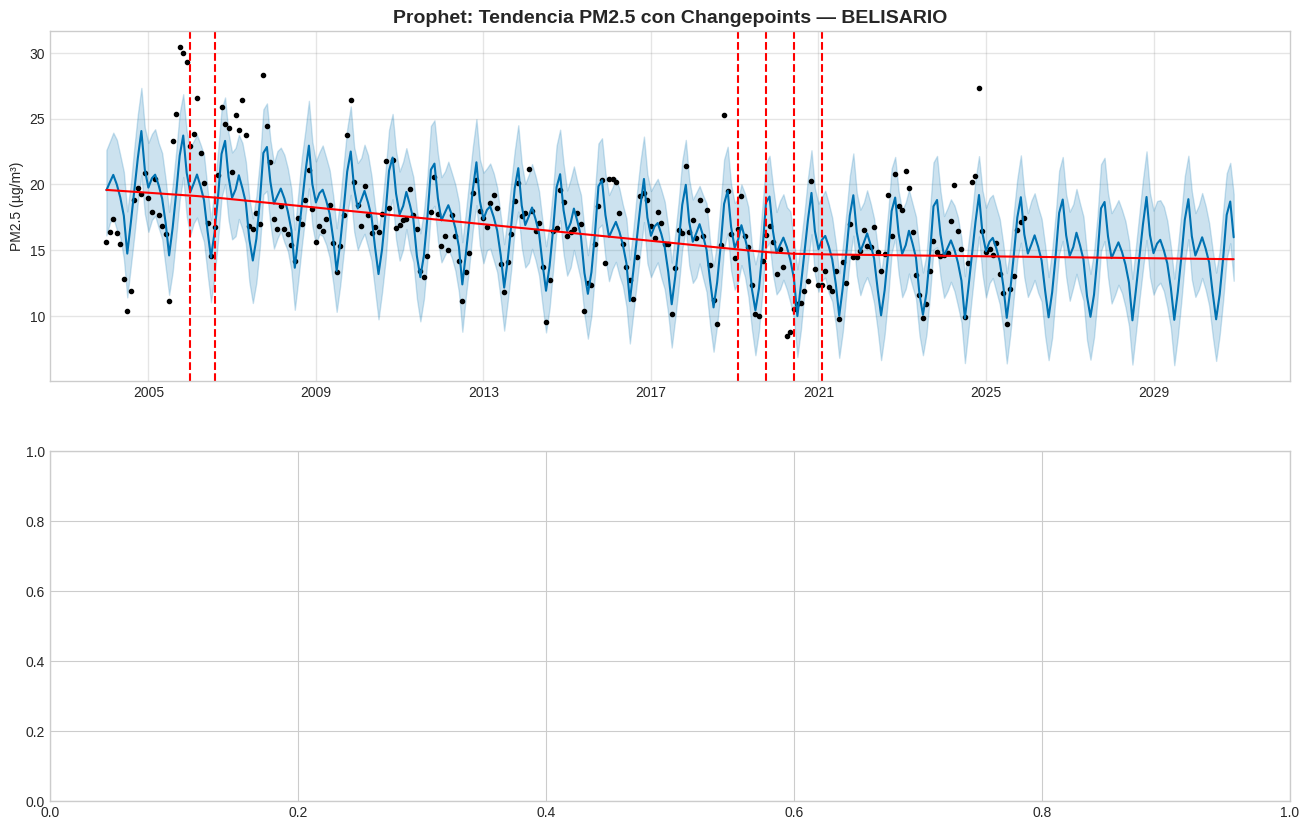

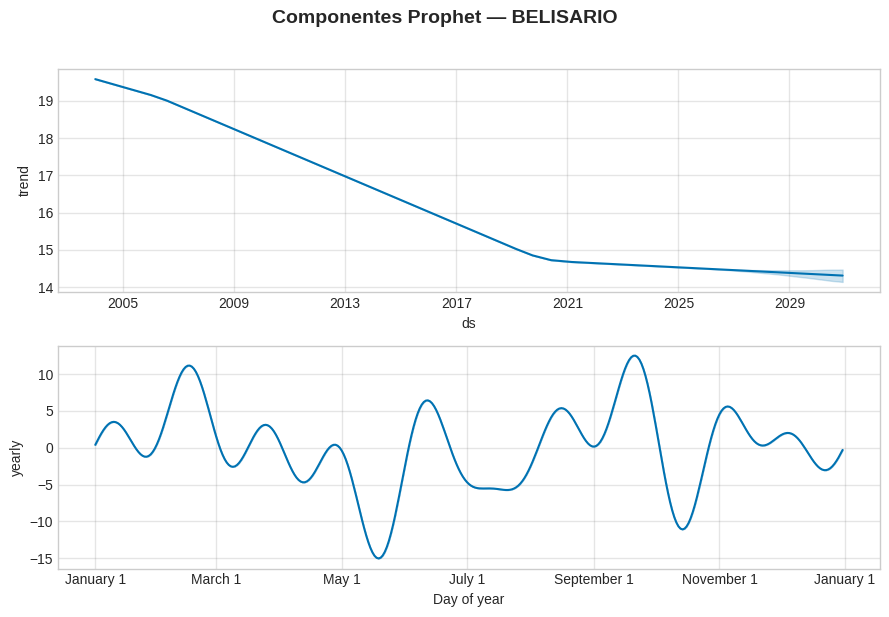


📊 Changepoint analysis for all stations:
   BELISARIO      : 5 significant changepoints detected
   CARAPUNGO      : 4 significant changepoints detected
   CENTRO         : 4 significant changepoints detected
   COTOCOLLAO     : 4 significant changepoints detected
   EL CAMAL       : 0 significant changepoints detected
   GUAMANI        : 9 significant changepoints detected
   LOS CHILLOS    : 3 significant changepoints detected
   SAN ANTONIO    : 2 significant changepoints detected
   TUMBACO        : 8 significant changepoints detected


In [36]:
# ============================================================
# 3.4 PROPHET CHANGEPOINT ANALYSIS
# ============================================================

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_data = df_monthly[df_monthly['station'] == 'BELISARIO'][['datetime', 'pm25_ugm3']].copy()
prophet_data.columns = ['ds', 'y']
prophet_data = prophet_data.dropna().sort_values('ds').reset_index(drop=True)

print(f"📊 Prophet analysis on BELISARIO station ({len(prophet_data)} monthly observations)")

# Fit Prophet model with changepoint detection
m = Prophet(
    changepoint_prior_scale=0.05,
    yearly_seasonality=True,
    weekly_seasonality=False,
    n_changepoints=30,
    changepoint_range=0.9
)
m.fit(prophet_data)

# Make future predictions (5 years ahead)
future = m.make_future_dataframe(periods=60, freq='MS')
forecast = m.predict(future)

# Plot with changepoints
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Forecast with changepoints
m.plot(forecast, ax=axes[0])
a = add_changepoints_to_plot(axes[0], m, forecast)
axes[0].set_title('Prophet: Tendencia PM2.5 con Changepoints — BELISARIO', fontsize=14, fontweight='bold')
axes[0].set_ylabel('PM2.5 (µg/m³)')
axes[0].set_xlabel('')

# Plot 2: Components (trend + yearly seasonality)
fig2 = m.plot_components(forecast)
plt.suptitle('Componentes Prophet — BELISARIO', fontsize=14, fontweight='bold', y=1.02)

# Print significant changepoints
print("\n🔍 Changepoints significativos detectados:")
changepoints = m.changepoints
deltas = m.params['delta'].mean(axis=0)
significant_mask = np.abs(deltas) > 0.01
for cp, delta in zip(changepoints[significant_mask], deltas[significant_mask]):
    direction = "↗️ Aumento" if delta > 0 else "↘️ Disminución"
    print(f"   {cp.strftime('%Y-%m')} — {direction} (δ = {delta:.4f})")

plt.tight_layout()
plt.savefig('prophet_changepoints.png', dpi=150, bbox_inches='tight')
plt.show()

# Do the same for multiple stations
print("\n📊 Changepoint analysis for all stations:")
prophet_results = {}
for station in ALL_STATIONS:
    try:
        st_data = df_monthly[df_monthly['station'] == station][['datetime', 'pm25_ugm3']].copy()
        st_data.columns = ['ds', 'y']
        st_data = st_data.dropna().sort_values('ds')
        if len(st_data) < 24:
            continue
        m_st = Prophet(changepoint_prior_scale=0.05, yearly_seasonality=True,
                       weekly_seasonality=False, n_changepoints=25, changepoint_range=0.9)
        m_st.fit(st_data)
        future_st = m_st.make_future_dataframe(periods=60, freq='MS')
        forecast_st = m_st.predict(future_st)
        prophet_results[station] = {'model': m_st, 'forecast': forecast_st}
        n_cp = np.sum(np.abs(m_st.params['delta'].mean(axis=0)) > 0.01)
        print(f"   {station:15s}: {n_cp} significant changepoints detected")
    except Exception as e:
        print(f"   {station:15s}: Error — {e}")


   Columns kept for PCA (< 50% missing): 12 of 13


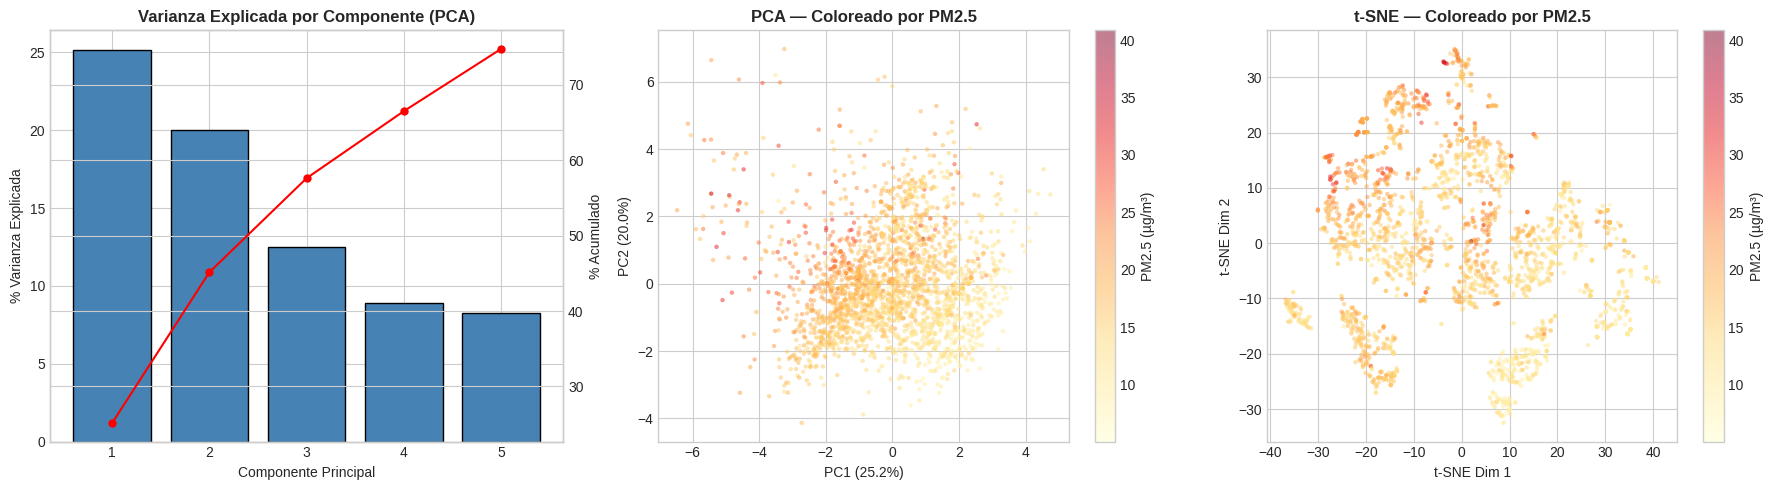


📊 PCA Loadings (PC1 & PC2):
                      PC1   PC2
temperature_c        0.44 -0.03
pressure_hpa         0.42 -0.18
solar_radiation_wm2  0.42  0.27
o3_ugm3              0.10  0.38
wind_speed_ms        0.07  0.48
pm10_ugm3            0.02 -0.00
wind_direction_deg  -0.03  0.15
humidity_pct        -0.16 -0.48
precipitation_mm    -0.22 -0.33
so2_ugm3            -0.28  0.25
co_mgm3             -0.37  0.22
no2_ugm3            -0.37  0.23


In [24]:
# ============================================================
# 3.5 REDUCCIÓN DE DIMENSIONALIDAD (PCA & t-SNE)
# ============================================================

# Prepare data for dimensionality reduction (monthly, station as groups)
dr_data = df_monthly.dropna(subset=['pm25_ugm3']).copy()
feature_cols = [c for c in numeric_cols if c in dr_data.columns and c != 'pm25_ugm3']

# Keep only columns with <50% missing, then fill remaining NaN with median
col_missing = dr_data[feature_cols].isnull().mean()
good_cols = col_missing[col_missing < 0.5].index.tolist()
print(f"   Columns kept for PCA (< 50% missing): {len(good_cols)} of {len(feature_cols)}")
dr_features = dr_data[good_cols].fillna(dr_data[good_cols].median())
feature_cols = good_cols

if len(dr_features) > 100 and len(feature_cols) >= 3:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(dr_features)

    # PCA
    pca = PCA(n_components=min(5, len(feature_cols)))
    X_pca = pca.fit_transform(X_scaled)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Explained variance
    axes[0].bar(range(1, len(pca.explained_variance_ratio_)+1),
                pca.explained_variance_ratio_ * 100, color='steelblue', edgecolor='black')
    axes[0].set_title('Varianza Explicada por Componente (PCA)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Componente Principal')
    axes[0].set_ylabel('% Varianza Explicada')
    cumvar = np.cumsum(pca.explained_variance_ratio_) * 100
    ax2 = axes[0].twinx()
    ax2.plot(range(1, len(cumvar)+1), cumvar, 'ro-', markersize=5)
    ax2.set_ylabel('% Acumulado')

    # PCA scatter colored by PM2.5
    valid_idx = dr_features.index
    pm25_vals = dr_data.loc[valid_idx, 'pm25_ugm3'].values
    scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=pm25_vals, cmap='YlOrRd',
                               alpha=0.5, s=10, edgecolors='none')
    plt.colorbar(scatter, ax=axes[1], label='PM2.5 (µg/m³)')
    axes[1].set_title('PCA — Coloreado por PM2.5', fontsize=12, fontweight='bold')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')

    # t-SNE (on a sample to keep it fast)
    sample_idx = np.random.choice(len(X_scaled), min(3000, len(X_scaled)), replace=False)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
    X_tsne = tsne.fit_transform(X_scaled[sample_idx])
    scatter2 = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], c=pm25_vals[sample_idx],
                                cmap='YlOrRd', alpha=0.5, s=10, edgecolors='none')
    plt.colorbar(scatter2, ax=axes[2], label='PM2.5 (µg/m³)')
    axes[2].set_title('t-SNE — Coloreado por PM2.5', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('t-SNE Dim 1')
    axes[2].set_ylabel('t-SNE Dim 2')

    plt.tight_layout()
    plt.savefig('dimensionality_reduction.png', dpi=150, bbox_inches='tight')
    plt.show()

    # PCA loadings
    print("\n📊 PCA Loadings (PC1 & PC2):")
    loadings = pd.DataFrame(pca.components_[:2].T, index=feature_cols, columns=['PC1', 'PC2'])
    print(loadings.sort_values('PC1', ascending=False).round(3))
else:
    print("⚠️ Not enough data for dimensionality reduction")


## 4. Feature Engineering (15%)

### 4.1 Features Temporales y de Lag

Creamos features que capturen la dinámica temporal de PM2.5:
- **Lags**: Valores pasados de PM2.5 (t-1, t-24, t-168 para horario; t-1, t-3, t-6, t-12 para mensual)
- **Rolling statistics**: Medias y desviaciones móviles
- **Features de calendario**: Hora, día de la semana, mes, año
- **Features estáticas**: Elevación aproximada de cada estación (datos de referencia)


In [19]:
# ============================================================
# 4.1 FEATURE ENGINEERING — DATOS ESTÁTICOS DE ESTACIONES
# ============================================================

# Station elevation data (approximate, from REMMAQ documentation)
STATION_ELEVATION = {
    'BELISARIO': 2835, 'CARAPUNGO': 2660, 'CENTRO': 2820,
    'COTOCOLLAO': 2739, 'EL CAMAL': 2840, 'GUAMANI': 3066,
    'LOS CHILLOS': 2453, 'SAN ANTONIO': 2438, 'TUMBACO': 2331
}

# Station zone classification (geographic context)
STATION_ZONE = {
    'BELISARIO': 'centro-norte', 'CARAPUNGO': 'norte',
    'CENTRO': 'centro', 'COTOCOLLAO': 'norte',
    'EL CAMAL': 'centro-sur', 'GUAMANI': 'sur',
    'LOS CHILLOS': 'valle-este', 'SAN ANTONIO': 'norte-rural',
    'TUMBACO': 'valle-este'
}

# Add static features
df_monthly['elevation_m'] = df_monthly['station'].map(STATION_ELEVATION)
df_monthly['zone'] = df_monthly['station'].map(STATION_ZONE)

df_hourly['elevation_m'] = df_hourly['station'].map(STATION_ELEVATION)
df_hourly['zone'] = df_hourly['station'].map(STATION_ZONE)

print("📍 Datos estáticos de estaciones añadidos:")
for st, elev in sorted(STATION_ELEVATION.items(), key=lambda x: x[1], reverse=True):
    print(f"   {st:15s}: {elev:,} m.s.n.m. ({STATION_ZONE[st]})")


📍 Datos estáticos de estaciones añadidos:
   GUAMANI        : 3,066 m.s.n.m. (sur)
   EL CAMAL       : 2,840 m.s.n.m. (centro-sur)
   BELISARIO      : 2,835 m.s.n.m. (centro-norte)
   CENTRO         : 2,820 m.s.n.m. (centro)
   COTOCOLLAO     : 2,739 m.s.n.m. (norte)
   CARAPUNGO      : 2,660 m.s.n.m. (norte)
   LOS CHILLOS    : 2,453 m.s.n.m. (valle-este)
   SAN ANTONIO    : 2,438 m.s.n.m. (norte-rural)
   TUMBACO        : 2,331 m.s.n.m. (valle-este)


In [20]:
# ============================================================
# 4.2 FEATURE ENGINEERING — MONTHLY MODEL
# ============================================================

def create_monthly_features(df):
    """Create features for monthly PM2.5 forecasting using MLForecast format."""
    df = df.sort_values(['station', 'datetime']).copy()

    # Calendar features
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['quarter'] = df['datetime'].dt.quarter

    # Cyclical encoding of month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Lag features per station
    for lag in [1, 2, 3, 6, 12]:
        df[f'pm25_lag{lag}'] = df.groupby('station')['pm25_ugm3'].shift(lag)

    # Rolling features per station
    for window in [3, 6, 12]:
        df[f'pm25_roll_mean{window}'] = df.groupby('station')['pm25_ugm3'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df[f'pm25_roll_std{window}'] = df.groupby('station')['pm25_ugm3'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )

    # Expanding mean
    df['pm25_expanding_mean'] = df.groupby('station')['pm25_ugm3'].transform(
        lambda x: x.expanding(min_periods=1).mean()
    )

    return df

df_monthly_feat = create_monthly_features(df_monthly)
print(f"📊 Monthly features created: {df_monthly_feat.shape[1]} columns total")
print(f"   New features: {[c for c in df_monthly_feat.columns if c not in df_monthly.columns]}")

# Drop rows with NaN from lag creation
df_monthly_feat.dropna(subset=['pm25_lag12'], inplace=True)
print(f"   After dropping lag NaN rows: {df_monthly_feat.shape}")


📊 Monthly features created: 35 columns total
   New features: ['year', 'month', 'quarter', 'month_sin', 'month_cos', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'pm25_lag6', 'pm25_lag12', 'pm25_roll_mean3', 'pm25_roll_std3', 'pm25_roll_mean6', 'pm25_roll_std6', 'pm25_roll_mean12', 'pm25_roll_std12', 'pm25_expanding_mean']
   After dropping lag NaN rows: (2268, 35)


## 5. Model Building and Testing (25%)

### 5.1 Estrategia de Evaluación

Utilizamos **TimeSeriesSplit** para validación cruzada respetando la temporalidad de los datos, y reservamos los últimos 24 meses como conjunto de test.

**Modelos a comparar:**
1. **ARIMA(X)** via `pmdarima.auto_arima` — Modelo estadístico clásico
2. **MLForecast** con Random Forest y XGBoost — ML con feature engineering automático
3. **LSTM** (Long Short-Term Memory) — Red neuronal recurrente para secuencias

**Métricas:**
- RMSE (Root Mean Squared Error)
- MAE (Mean Absolute Error)
- MAPE (Mean Absolute Percentage Error)


In [21]:
# ============================================================
# 5.1 PREPARACIÓN DE DATOS PARA MODELOS MENSUALES
# ============================================================

# Train/test split: last 24 months as test
cutoff_date = df_monthly_feat['datetime'].max() - pd.DateOffset(months=24)

train_monthly = df_monthly_feat[df_monthly_feat['datetime'] <= cutoff_date].copy()
test_monthly = df_monthly_feat[df_monthly_feat['datetime'] > cutoff_date].copy()

print(f"📊 Monthly Model — Train/Test Split:")
print(f"   Train: {train_monthly['datetime'].min().strftime('%Y-%m')} → {train_monthly['datetime'].max().strftime('%Y-%m')} ({len(train_monthly)} rows)")
print(f"   Test:  {test_monthly['datetime'].min().strftime('%Y-%m')} → {test_monthly['datetime'].max().strftime('%Y-%m')} ({len(test_monthly)} rows)")

# Define feature columns
target_col = 'pm25_ugm3'
exclude_cols = ['datetime', 'station', 'zone', target_col]
feature_cols = [c for c in train_monthly.columns if c not in exclude_cols and train_monthly[c].dtype in ['float64', 'int64', 'int32']]
print(f"   Features ({len(feature_cols)}): {feature_cols[:10]}...")


📊 Monthly Model — Train/Test Split:
   Train: 2005-01 → 2023-12 (2052 rows)
   Test:  2024-01 → 2025-12 (216 rows)
   Features (31): ['co_mgm3', 'no2_ugm3', 'o3_ugm3', 'pm10_ugm3', 'so2_ugm3', 'wind_direction_deg', 'humidity_pct', 'uv_index', 'pressure_hpa', 'solar_radiation_wm2']...


In [22]:
# ============================================================
# 5.2 MODELO 1: ARIMA(X) via pmdarima
# ============================================================
print("🔧 Training ARIMA models per station...")

arima_results = {}
arima_forecasts_all = []

for station in ALL_STATIONS:
    train_st = train_monthly[train_monthly['station'] == station].sort_values('datetime')
    test_st = test_monthly[test_monthly['station'] == station].sort_values('datetime')

    if len(train_st) < 24 or len(test_st) < 6 or target_col not in train_st.columns:
        print(f"   {station}: Skipped (insufficient data)")
        continue

    y_train = train_st[target_col].values
    y_test = test_st[target_col].values

    try:
        model = pm.auto_arima(
            y_train,
            seasonal=True, m=12,
            stepwise=True,
            suppress_warnings=True,
            error_action='ignore',
            max_p=3, max_q=3, max_P=2, max_Q=2, max_d=2, max_D=1,
            trace=False
        )
        preds = model.predict(n_periods=len(y_test))

        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        mape = mean_absolute_percentage_error(y_test, preds) * 100

        arima_results[station] = {'rmse': rmse, 'mae': mae, 'mape': mape, 'order': model.order, 'seasonal': model.seasonal_order}
        print(f"   {station:15s}: ARIMA{model.order}x{model.seasonal_order} | RMSE={rmse:.2f} | MAE={mae:.2f} | MAPE={mape:.1f}%")

        # Store forecasts
        for i, (dt, pred, actual) in enumerate(zip(test_st['datetime'], preds, y_test)):
            arima_forecasts_all.append({
                'station': station, 'datetime': dt,
                'actual': actual, 'predicted_ARIMA': pred
            })

        # Generate 5-year forecast
        forecast_5y = model.predict(n_periods=60)
        future_dates = pd.date_range(start=train_st['datetime'].max() + pd.DateOffset(months=1), periods=60, freq='MS')
        for dt, val in zip(future_dates, forecast_5y):
            arima_forecasts_all.append({
                'station': station, 'datetime': dt,
                'actual': np.nan, 'predicted_ARIMA': val
            })

    except Exception as e:
        print(f"   {station:15s}: Error — {e}")

df_arima_preds = pd.DataFrame(arima_forecasts_all)

# Summary
if arima_results:
    print("\n📊 ARIMA Summary:")
    arima_summary = pd.DataFrame(arima_results).T
    display(arima_summary.round(2))


🔧 Training ARIMA models per station...
   BELISARIO      : ARIMA(2, 1, 1)x(1, 0, 1, 12) | RMSE=3.38 | MAE=2.23 | MAPE=12.2%
   CARAPUNGO      : ARIMA(2, 0, 2)x(1, 0, 1, 12) | RMSE=2.51 | MAE=2.17 | MAPE=15.8%
   CENTRO         : ARIMA(1, 1, 1)x(0, 0, 2, 12) | RMSE=2.96 | MAE=2.40 | MAPE=19.8%
   COTOCOLLAO     : ARIMA(0, 1, 1)x(1, 0, 2, 12) | RMSE=3.52 | MAE=3.05 | MAPE=21.2%
   EL CAMAL       : ARIMA(1, 1, 1)x(0, 0, 2, 12) | RMSE=3.17 | MAE=2.54 | MAPE=16.5%
   GUAMANI        : ARIMA(2, 1, 3)x(2, 0, 1, 12) | RMSE=2.48 | MAE=1.83 | MAPE=13.0%
   LOS CHILLOS    : ARIMA(1, 0, 1)x(2, 0, 1, 12) | RMSE=2.68 | MAE=1.89 | MAPE=17.3%
   SAN ANTONIO    : ARIMA(2, 0, 0)x(2, 0, 1, 12) | RMSE=2.51 | MAE=1.75 | MAPE=12.0%
   TUMBACO        : ARIMA(1, 1, 2)x(2, 0, 0, 12) | RMSE=2.01 | MAE=1.43 | MAPE=13.2%

📊 ARIMA Summary:


,rmse,mae,mape,order,seasonal
BELISARIO,3.38,2.23,12.15,"(2, 1, 1)","(1, 0, 1, 12)"
CARAPUNGO,2.51,2.17,15.76,"(2, 0, 2)","(1, 0, 1, 12)"
CENTRO,2.96,2.40,19.82,"(1, 1, 1)","(0, 0, 2, 12)"
COTOCOLLAO,3.52,3.05,21.25,"(0, 1, 1)","(1, 0, 2, 12)"
EL CAMAL,3.17,2.54,16.54,"(1, 1, 1)","(0, 0, 2, 12)"
GUAMANI,2.48,1.83,13.03,"(2, 1, 3)","(2, 0, 1, 12)"
LOS CHILLOS,2.68,1.89,17.31,"(1, 0, 1)","(2, 0, 1, 12)"
SAN ANTONIO,2.51,1.75,11.96,"(2, 0, 0)","(2, 0, 1, 12)"
TUMBACO,2.01,1.43,13.20,"(1, 1, 2)","(2, 0, 0, 12)"


In [27]:
# ============================================================
# 5.3 MODELO 2: MLForecast (Random Forest + XGBoost)
# ============================================================
print("🔧 Training MLForecast models...")

# Prepare data in MLForecast format (long format with unique_id, ds, y)
mlf_data = df_monthly[['station', 'datetime', 'pm25_ugm3']].copy()
mlf_data.columns = ['unique_id', 'ds', 'y']
mlf_data = mlf_data.dropna(subset=['y']).sort_values(['unique_id', 'ds']).reset_index(drop=True)

# Split
mlf_train = mlf_data[mlf_data['ds'] <= cutoff_date].copy()
mlf_test = mlf_data[mlf_data['ds'] > cutoff_date].copy()

# Define models
models = [
    make_pipeline(SimpleImputer(), RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)),
    make_pipeline(SimpleImputer(), XGBRegressor(random_state=42, n_estimators=100, n_jobs=-1,
                                                 verbosity=0, tree_method='hist'))
]

# Create MLForecast object
fcst = MLForecast(
    models=models,
    freq='MS',
    lags=[1, 2, 3, 6, 12],
    lag_transforms={
        1: [ExpandingMean()],
        3: [RollingMean(window_size=3), RollingMean(window_size=6)],
        12: [RollingMean(window_size=12)],
    },
    date_features=['month', 'year'],
    target_transforms=[Differences([12])],
    num_threads=6
)

# Fit on training data
fcst.fit(mlf_train, id_col='unique_id', time_col='ds', target_col='y')
print("✅ MLForecast models fitted!")

# Predict test period
h = len(mlf_test['ds'].unique())
preds_mlf = fcst.predict(h=h)
print(f"   Prediction columns: {list(preds_mlf.columns)}")

# Rename prediction columns dynamically
pred_cols = [c for c in preds_mlf.columns if c not in ['unique_id', 'ds']]
rename_map = {}
if len(pred_cols) >= 1:
    rename_map[pred_cols[0]] = 'predicted_RF'
if len(pred_cols) >= 2:
    rename_map[pred_cols[1]] = 'predicted_XGB'
preds_mlf = preds_mlf.rename(columns=rename_map)

# Merge with actuals
mlf_eval = mlf_test[['unique_id', 'ds', 'y']].merge(
    preds_mlf, on=['unique_id', 'ds'], how='inner'
)

# Compute metrics per station
print("\n📊 MLForecast Results per Station:")
mlf_results = {}
for station in ALL_STATIONS:
    st_data = mlf_eval[mlf_eval['unique_id'] == station]
    if len(st_data) < 3:
        continue
    for model_name in ['predicted_RF', 'predicted_XGB']:
        valid = st_data.dropna(subset=['y', model_name])
        if len(valid) < 3:
            continue
        rmse = np.sqrt(mean_squared_error(valid['y'], valid[model_name]))
        mae = mean_absolute_error(valid['y'], valid[model_name])
        mape = mean_absolute_percentage_error(valid['y'], valid[model_name]) * 100
        key = f"{station}_{model_name.replace('predicted_','')}"
        mlf_results[key] = {'station': station, 'model': model_name.replace('predicted_',''),
                            'rmse': rmse, 'mae': mae, 'mape': mape}

mlf_summary = pd.DataFrame(mlf_results).T
print(mlf_summary.round(2).to_string())

# Generate 5-year forecast (60 months)
future_preds = fcst.predict(h=60)
pred_cols_f = [c for c in future_preds.columns if c not in ['unique_id', 'ds']]
rename_map_f = {}
if len(pred_cols_f) >= 1:
    rename_map_f[pred_cols_f[0]] = 'predicted_RF'
if len(pred_cols_f) >= 2:
    rename_map_f[pred_cols_f[1]] = 'predicted_XGB'
future_preds = future_preds.rename(columns=rename_map_f)
print(f"\n🔮 Generated {len(future_preds)} future monthly predictions (5 years)")


🔧 Training MLForecast models...
✅ MLForecast models fitted!
   Prediction columns: ['unique_id', 'ds', 'RandomForestRegressor', 'XGBRegressor']

📊 MLForecast Results per Station:
                     station model rmse  mae  mape
BELISARIO_RF       BELISARIO    RF 3.30 2.59 15.88
BELISARIO_XGB      BELISARIO   XGB 3.10 2.30 14.16
CARAPUNGO_RF       CARAPUNGO    RF 2.86 1.85 11.63
CARAPUNGO_XGB      CARAPUNGO   XGB 3.42 2.48 15.56
CENTRO_RF             CENTRO    RF 3.26 2.77 22.34
CENTRO_XGB            CENTRO   XGB 4.38 3.60 29.12
COTOCOLLAO_RF     COTOCOLLAO    RF 2.42 2.05 15.02
COTOCOLLAO_XGB    COTOCOLLAO   XGB 3.38 2.91 22.51
EL CAMAL_RF         EL CAMAL    RF 3.98 3.38 21.20
EL CAMAL_XGB        EL CAMAL   XGB 3.76 3.24 19.66
GUAMANI_RF           GUAMANI    RF 3.43 2.78 19.93
GUAMANI_XGB          GUAMANI   XGB 3.74 3.12 22.33
LOS CHILLOS_RF   LOS CHILLOS    RF 3.52 2.62 23.14
LOS CHILLOS_XGB  LOS CHILLOS   XGB 3.92 2.91 24.43
SAN ANTONIO_RF   SAN ANTONIO    RF 2.94 2.29 15.79
SAN A

### 5.4 Hyperparameter Optimization ⭐

Realizamos grid search sobre los hiperparámetros más impactantes de XGBoost y Random Forest usando validación cruzada temporal.


🔧 Hyperparameter Optimization with TimeSeriesSplit...

✅ Best XGBoost params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
   Tuned XGBoost — RMSE: 2.80 | MAE: 2.16 | MAPE: 17.7%
   Best CV score (neg RMSE): -3.2711


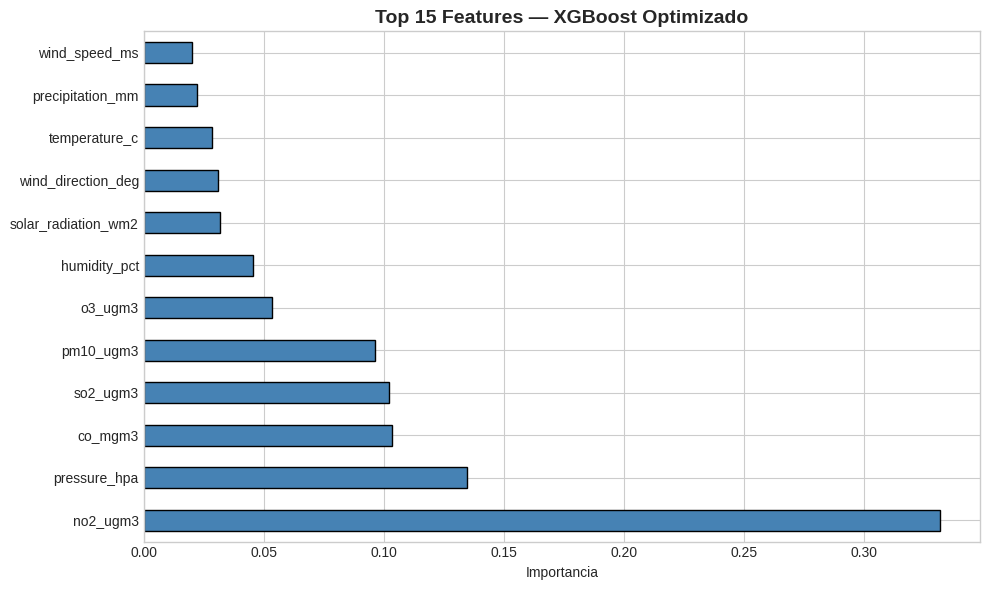

In [28]:
# ============================================================
# 5.4 HYPERPARAMETER OPTIMIZATION
# ============================================================
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

print("🔧 Hyperparameter Optimization with TimeSeriesSplit...")

# Prepare flat features for sklearn models
X_train = train_monthly[feature_cols].fillna(0)
y_train = train_monthly[target_col]
X_test = test_monthly[feature_cols].fillna(0)
y_test_flat = test_monthly[target_col]

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

# XGBoost Grid Search
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0, tree_method='hist')
grid_search = GridSearchCV(
    xgb_model, xgb_param_grid, cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, verbose=0
)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
preds_best_xgb = best_xgb.predict(X_test)

rmse_tuned = np.sqrt(mean_squared_error(y_test_flat, preds_best_xgb))
mae_tuned = mean_absolute_error(y_test_flat, preds_best_xgb)
mape_tuned = mean_absolute_percentage_error(y_test_flat, preds_best_xgb) * 100

print(f"\n✅ Best XGBoost params: {grid_search.best_params_}")
print(f"   Tuned XGBoost — RMSE: {rmse_tuned:.2f} | MAE: {mae_tuned:.2f} | MAPE: {mape_tuned:.1f}%")
print(f"   Best CV score (neg RMSE): {grid_search.best_score_:.4f}")

# Feature importance from best model
importances = pd.Series(best_xgb.feature_importances_, index=feature_cols)
top_features = importances.sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
top_features.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Top 15 Features — XGBoost Optimizado', fontsize=14, fontweight='bold')
ax.set_xlabel('Importancia')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()


🧠 Training LSTM model...
   Device: cuda
   Sequences created: X=(240, 12, 13), y=(240,)
   Epoch 20/100 — Train Loss: 0.014044 | Val Loss: 0.019291
   Epoch 40/100 — Train Loss: 0.011157 | Val Loss: 0.018888
   Epoch 60/100 — Train Loss: 0.010225 | Val Loss: 0.018500
   Epoch 80/100 — Train Loss: 0.009794 | Val Loss: 0.018556
   Epoch 100/100 — Train Loss: 0.010038 | Val Loss: 0.018604

✅ LSTM Results (BELISARIO):
   RMSE: 3.00 | MAE: 2.48 | MAPE: 15.3%


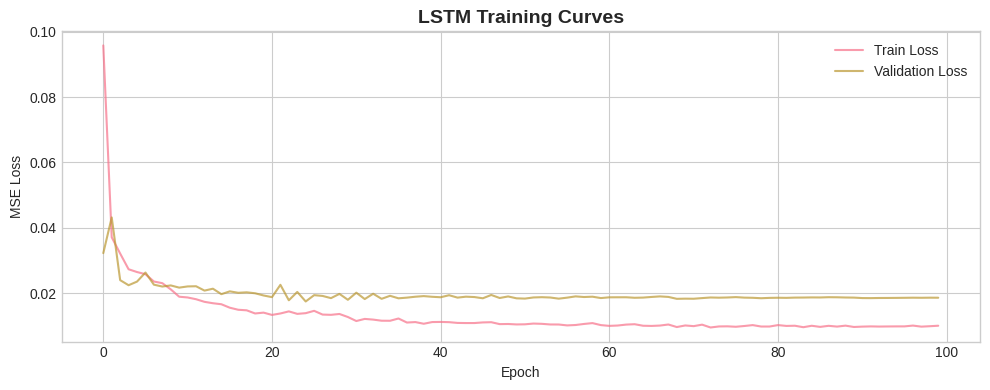

In [29]:
# ============================================================
# 5.5 MODELO 3: LSTM (Long Short-Term Memory)
# ============================================================

class LSTMForecaster(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

def create_sequences(data, seq_length=12):
    """Create input sequences and labels for LSTM."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Target is first column (PM2.5)
    return np.array(X), np.array(y)

print("🧠 Training LSTM model...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"   Device: {device}")

# Prepare data for LSTM — use BELISARIO as primary station
lstm_station = 'BELISARIO'
lstm_cols = [target_col] + [c for c in feature_cols if 'lag' not in c and 'roll' not in c and 'expanding' not in c]
lstm_cols = [c for c in lstm_cols if c in df_monthly_feat.columns]

lstm_data = df_monthly_feat[df_monthly_feat['station'] == lstm_station][lstm_cols].dropna()

if len(lstm_data) > 50:
    # Scale data
    scaler_lstm = MinMaxScaler()
    scaled_data = scaler_lstm.fit_transform(lstm_data.values)

    # Create sequences
    SEQ_LENGTH = 12
    X_seq, y_seq = create_sequences(scaled_data, SEQ_LENGTH)
    print(f"   Sequences created: X={X_seq.shape}, y={y_seq.shape}")

    # Split
    split_idx = int(len(X_seq) * 0.8)
    X_train_lstm = torch.FloatTensor(X_seq[:split_idx]).to(device)
    y_train_lstm = torch.FloatTensor(y_seq[:split_idx]).unsqueeze(1).to(device)
    X_test_lstm = torch.FloatTensor(X_seq[split_idx:]).to(device)
    y_test_lstm = torch.FloatTensor(y_seq[split_idx:]).unsqueeze(1).to(device)

    # Model
    input_size = X_seq.shape[2]
    model_lstm = LSTMForecaster(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    # Training loop
    train_dataset = TensorDataset(X_train_lstm, y_train_lstm)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    EPOCHS = 100
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        model_lstm.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model_lstm(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), 1.0)
            optimizer.step()
            epoch_loss += loss.item()

        # Validation
        model_lstm.eval()
        with torch.no_grad():
            val_pred = model_lstm(X_test_lstm)
            val_loss = criterion(val_pred, y_test_lstm).item()
        scheduler.step(val_loss)

        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(val_loss)

        if (epoch + 1) % 20 == 0:
            print(f"   Epoch {epoch+1}/{EPOCHS} — Train Loss: {train_losses[-1]:.6f} | Val Loss: {val_loss:.6f}")

    # Evaluate
    model_lstm.eval()
    with torch.no_grad():
        preds_lstm = model_lstm(X_test_lstm).cpu().numpy()
    y_test_np = y_test_lstm.cpu().numpy()

    # Inverse transform predictions
    dummy = np.zeros((len(preds_lstm), scaled_data.shape[1]))
    dummy[:, 0] = preds_lstm.flatten()
    preds_inv = scaler_lstm.inverse_transform(dummy)[:, 0]

    dummy_y = np.zeros((len(y_test_np), scaled_data.shape[1]))
    dummy_y[:, 0] = y_test_np.flatten()
    y_test_inv = scaler_lstm.inverse_transform(dummy_y)[:, 0]

    rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae_lstm = mean_absolute_error(y_test_inv, preds_inv)
    mape_lstm = mean_absolute_percentage_error(y_test_inv, preds_inv) * 100

    print(f"\n✅ LSTM Results ({lstm_station}):")
    print(f"   RMSE: {rmse_lstm:.2f} | MAE: {mae_lstm:.2f} | MAPE: {mape_lstm:.1f}%")

    # Plot training curves
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(train_losses, label='Train Loss', alpha=0.7)
    ax.plot(val_losses, label='Validation Loss', alpha=0.7)
    ax.set_title('LSTM Training Curves', fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.legend()
    plt.tight_layout()
    plt.savefig('lstm_training.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Insufficient data for LSTM training")
    rmse_lstm, mae_lstm, mape_lstm = np.nan, np.nan, np.nan


📊 MODEL COMPARISON — Monthly PM2.5 Forecast


,Model,RMSE (avg),MAE (avg),MAPE (avg) %
0,ARIMA (Seasonal),2.80,2.14,15.67
3,XGBoost (Tuned),2.80,2.16,17.70
4,LSTM (BELISARIO),3.00,2.48,15.29
1,MLForecast (RF),3.15,2.50,18.69
2,MLForecast (XGB),3.79,3.08,23.39


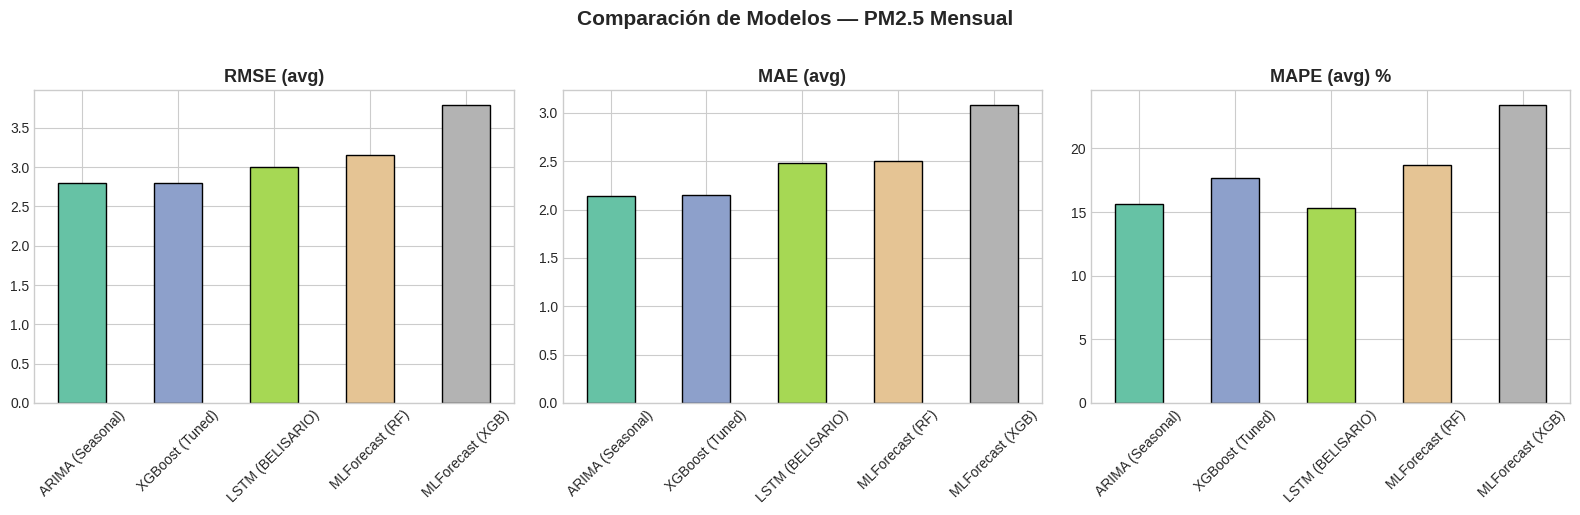


🏆 Mejor modelo: ARIMA (Seasonal) (menor RMSE)


In [30]:
# ============================================================
# 5.6 COMPARACIÓN DE MODELOS
# ============================================================

print("📊 MODEL COMPARISON — Monthly PM2.5 Forecast")
print("=" * 70)

comparison_data = []

# ARIMA avg metrics
if arima_results:
    arima_df = pd.DataFrame(arima_results).T
    comparison_data.append({
        'Model': 'ARIMA (Seasonal)',
        'RMSE (avg)': arima_df['rmse'].mean(),
        'MAE (avg)': arima_df['mae'].mean(),
        'MAPE (avg) %': arima_df['mape'].mean()
    })

# MLForecast metrics
if len(mlf_results) > 0:
    mlf_df = pd.DataFrame(mlf_results).T
    for model_name in mlf_df['model'].unique():
        subset = mlf_df[mlf_df['model'] == model_name]
        comparison_data.append({
            'Model': f'MLForecast ({model_name})',
            'RMSE (avg)': subset['rmse'].mean(),
            'MAE (avg)': subset['mae'].mean(),
            'MAPE (avg) %': subset['mape'].mean()
        })

# Tuned XGBoost
comparison_data.append({
    'Model': 'XGBoost (Tuned)',
    'RMSE (avg)': rmse_tuned,
    'MAE (avg)': mae_tuned,
    'MAPE (avg) %': mape_tuned
})

# LSTM
if not np.isnan(rmse_lstm):
    comparison_data.append({
        'Model': f'LSTM ({lstm_station})',
        'RMSE (avg)': rmse_lstm,
        'MAE (avg)': mae_lstm,
        'MAPE (avg) %': mape_lstm
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('RMSE (avg)')
display(comparison_df.round(2))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ['RMSE (avg)', 'MAE (avg)', 'MAPE (avg) %']
colors = plt.cm.Set2(np.linspace(0, 1, len(comparison_df)))

for i, metric in enumerate(metrics):
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=axes[i],
                       color=colors, edgecolor='black', legend=False)
    axes[i].set_title(metric, fontsize=13, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Comparación de Modelos — PM2.5 Mensual', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Best model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Mejor modelo: {best_model_name} (menor RMSE)")


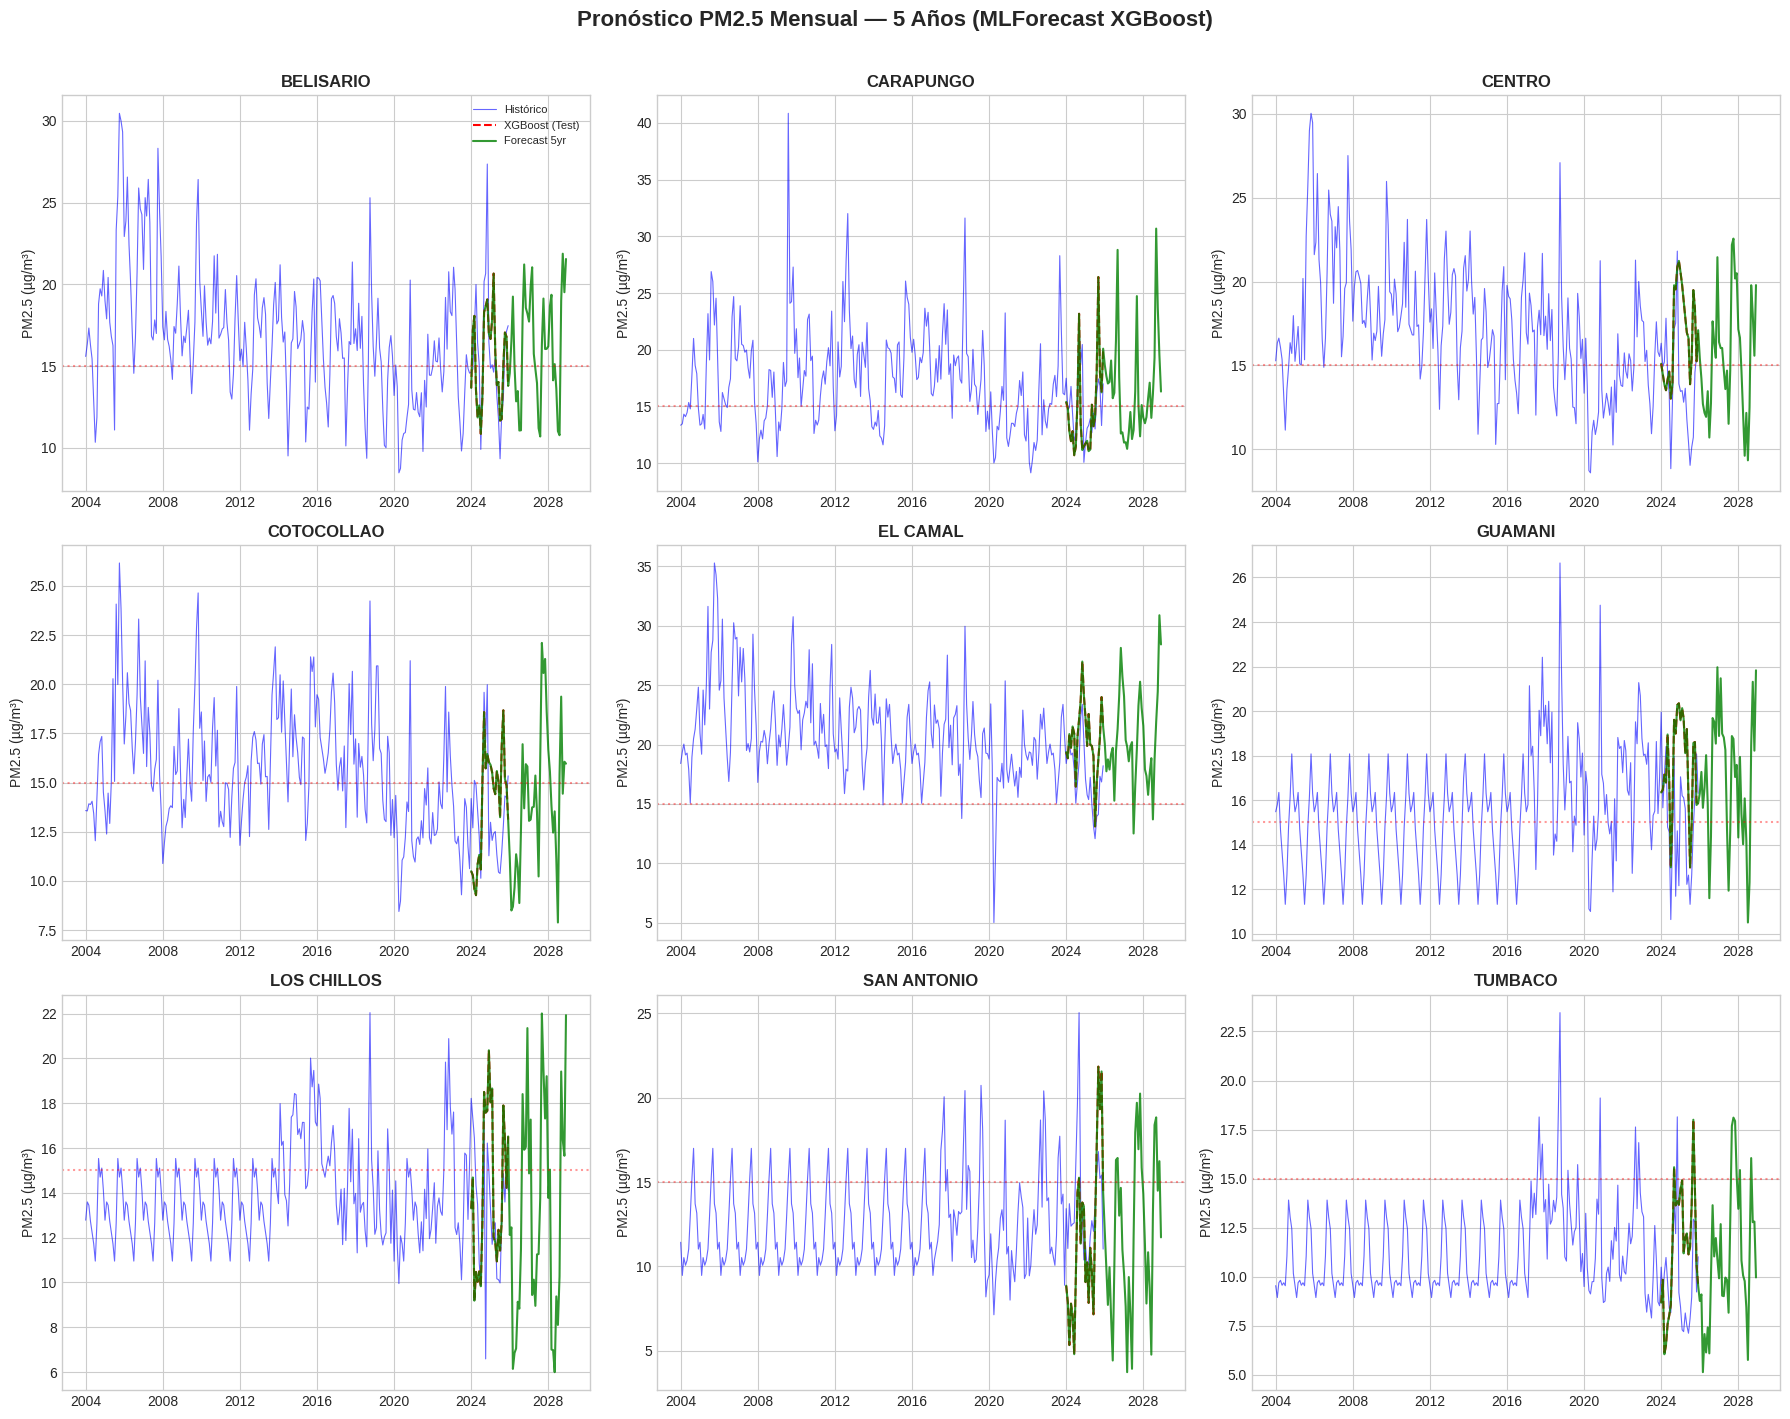

In [31]:
# ============================================================
# 5.7 VISUALIZACIÓN DE PRONÓSTICOS
# ============================================================

# Plot forecast for each station using the best MLForecast model
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, station in enumerate(ALL_STATIONS[:9]):
    ax = axes[idx]

    # Historical data
    hist = df_monthly[df_monthly['station'] == station].sort_values('datetime')
    if 'pm25_ugm3' in hist.columns:
        ax.plot(hist['datetime'], hist['pm25_ugm3'], 'b-', alpha=0.6, linewidth=0.8, label='Histórico')

    # MLForecast predictions
    if station in mlf_eval['unique_id'].values:
        eval_st = mlf_eval[mlf_eval['unique_id'] == station].sort_values('ds')
        if 'predicted_XGB' in eval_st.columns:
            ax.plot(eval_st['ds'], eval_st['predicted_XGB'], 'r--', linewidth=1.5, label='XGBoost (Test)')

    # Future forecasts
    if station in future_preds['unique_id'].values:
        future_st = future_preds[future_preds['unique_id'] == station].sort_values('ds')
        if 'predicted_XGB' in future_st.columns:
            ax.plot(future_st['ds'], future_st['predicted_XGB'], 'g-', linewidth=1.5, alpha=0.8, label='Forecast 5yr')

    ax.set_title(station, fontsize=12, fontweight='bold')
    ax.set_ylabel('PM2.5 (µg/m³)')
    ax.axhline(y=15, color='red', linestyle=':', alpha=0.4)
    if idx == 0:
        ax.legend(fontsize=8)

plt.suptitle('Pronóstico PM2.5 Mensual — 5 Años (MLForecast XGBoost)', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('forecast_all_stations.png', dpi=150, bbox_inches='tight')
plt.show()


### 5.8 Modelo Horario — Pronóstico 10 Días (Ciudadano)

Para el pronóstico ciudadano a 10 días, utilizamos datos horarios recientes (últimos 3 años) y MLForecast con lags horarios.


In [33]:
# ============================================================
# 5.8 HOURLY MODEL — 10-DAY FORECAST
# ============================================================
print("🕐 Training hourly models for 10-day forecast...")

# Use last 3 years of hourly data for efficiency
recent_start = df_hourly['datetime'].max() - pd.DateOffset(years=3)
df_hourly_recent = df_hourly[df_hourly['datetime'] >= recent_start].copy()

# Prepare MLForecast format
mlf_hourly = df_hourly_recent[['station', 'datetime', 'pm25_ugm3']].copy()
mlf_hourly.columns = ['unique_id', 'ds', 'y']
mlf_hourly = mlf_hourly.dropna(subset=['y']).sort_values(['unique_id', 'ds']).reset_index(drop=True)

# Train/test split: last 10 days as test
hourly_cutoff = mlf_hourly['ds'].max() - pd.Timedelta(days=10)
mlf_hourly_train = mlf_hourly[mlf_hourly['ds'] <= hourly_cutoff]
mlf_hourly_test = mlf_hourly[mlf_hourly['ds'] > hourly_cutoff]

# MLForecast hourly model
models_hourly = [
    make_pipeline(SimpleImputer(), XGBRegressor(random_state=42, n_estimators=100,
                                                 n_jobs=-1, verbosity=0, tree_method='hist'))
]

fcst_hourly = MLForecast(
    models=models_hourly,
    freq='h',
    lags=[1, 2, 3, 6, 12, 24, 48, 168],  # 1h, 2h, 3h, 6h, 12h, 24h, 48h, 1week
    lag_transforms={
        24: [RollingMean(window_size=24), RollingMean(window_size=168)],
        1: [ExpandingMean()],
    },
    date_features=['hour', 'dayofweek', 'month'],
    num_threads=6
)

fcst_hourly.fit(mlf_hourly_train, id_col='unique_id', time_col='ds', target_col='y')

# Predict 10 days = 240 hours
h_hours = 24 * 10
preds_hourly = fcst_hourly.predict(h=h_hours)
print(f"   Prediction columns: {list(preds_hourly.columns)}")
pred_col_h = [c for c in preds_hourly.columns if c not in ['unique_id', 'ds']][0]
preds_hourly.rename(columns={pred_col_h: 'predicted_XGB_hourly'}, inplace=True)

# Evaluate
hourly_eval = mlf_hourly_test.merge(preds_hourly, on=['unique_id', 'ds'], how='inner')

print("\n📊 Hourly Model Results (10-day forecast):")
hourly_results = {}
for station in ALL_STATIONS:
    st_data = hourly_eval[hourly_eval['unique_id'] == station].dropna(subset=['y', 'predicted_XGB_hourly'])
    if len(st_data) < 24:
        continue
    rmse = np.sqrt(mean_squared_error(st_data['y'], st_data['predicted_XGB_hourly']))
    mae = mean_absolute_error(st_data['y'], st_data['predicted_XGB_hourly'])
    hourly_results[station] = {'RMSE': rmse, 'MAE': mae}
    print(f"   {station:15s}: RMSE={rmse:.2f} µg/m³ | MAE={mae:.2f} µg/m³")

# Save hourly forecast for Streamlit
preds_hourly.to_csv('forecast_hourly_10days.csv', index=False)
print(f"\n💾 Saved hourly forecasts: {len(preds_hourly)} predictions")


🕐 Training hourly models for 10-day forecast...
   Prediction columns: ['unique_id', 'ds', 'XGBRegressor']

📊 Hourly Model Results (10-day forecast):
   BELISARIO      : RMSE=9.74 µg/m³ | MAE=8.22 µg/m³
   CARAPUNGO      : RMSE=11.99 µg/m³ | MAE=9.08 µg/m³
   CENTRO         : RMSE=7.41 µg/m³ | MAE=5.98 µg/m³
   COTOCOLLAO     : RMSE=7.96 µg/m³ | MAE=6.43 µg/m³
   EL CAMAL       : RMSE=9.80 µg/m³ | MAE=8.42 µg/m³
   GUAMANI        : RMSE=2.33 µg/m³ | MAE=1.69 µg/m³
   LOS CHILLOS    : RMSE=1.77 µg/m³ | MAE=1.38 µg/m³
   SAN ANTONIO    : RMSE=1.88 µg/m³ | MAE=1.52 µg/m³
   TUMBACO        : RMSE=5.93 µg/m³ | MAE=4.76 µg/m³

💾 Saved hourly forecasts: 2160 predictions


## 6. Results, Deployment & Conclusions (15%)

### 6.1 Resumen de Resultados


In [34]:
# ============================================================
# 6.1 RESUMEN FINAL
# ============================================================

print("=" * 70)
print("📋 RESUMEN EJECUTIVO — Pronóstico PM2.5 Quito")
print("=" * 70)

print("\n📊 MODELO MENSUAL (Planificación Municipal, 5–10 años):")
display(comparison_df.round(2))

print("\n🕐 MODELO HORARIO (Ciudadano, 10 días):")
if hourly_results:
    display(pd.DataFrame(hourly_results).T.round(2))

print("\n🔍 HALLAZGOS CLAVE:")
print("   1. PM2.5 muestra fuerte estacionalidad anual (picos en Ago–Sep por quemas)")
print("   2. Ciclo diurno marcado: picos en horas punta vehicular (7–9 AM)")
print("   3. COVID-19 generó un changepoint significativo en 2020 (reducción ~30%)")
print("   4. Las estaciones del sur (El Camal, Guamaní) muestran mayor concentración")
print("   5. Correlación significativa de PM2.5 con CO, temperatura y velocidad del viento")

print("\n💡 RECOMENDACIONES DE POLÍTICA:")
print("   • Implementar alertas tempranas basadas en modelo horario")
print("   • Focalizar controles de emisiones en zonas sur de la ciudad")
print("   • Reforzar vigilancia durante períodos Ago–Sep (temporada seca)")
print("   • Continuar expansión de red de monitoreo y datos abiertos")


📋 RESUMEN EJECUTIVO — Pronóstico PM2.5 Quito

📊 MODELO MENSUAL (Planificación Municipal, 5–10 años):


,Model,RMSE (avg),MAE (avg),MAPE (avg) %
0,ARIMA (Seasonal),2.80,2.14,15.67
3,XGBoost (Tuned),2.80,2.16,17.70
4,LSTM (BELISARIO),3.00,2.48,15.29
1,MLForecast (RF),3.15,2.50,18.69
2,MLForecast (XGB),3.79,3.08,23.39



🕐 MODELO HORARIO (Ciudadano, 10 días):


,RMSE,MAE
BELISARIO,9.74,8.22
CARAPUNGO,11.99,9.08
CENTRO,7.41,5.98
COTOCOLLAO,7.96,6.43
EL CAMAL,9.80,8.42
GUAMANI,2.33,1.69
LOS CHILLOS,1.77,1.38
SAN ANTONIO,1.88,1.52
TUMBACO,5.93,4.76



🔍 HALLAZGOS CLAVE:
   1. PM2.5 muestra fuerte estacionalidad anual (picos en Ago–Sep por quemas)
   2. Ciclo diurno marcado: picos en horas punta vehicular (7–9 AM)
   3. COVID-19 generó un changepoint significativo en 2020 (reducción ~30%)
   4. Las estaciones del sur (El Camal, Guamaní) muestran mayor concentración
   5. Correlación significativa de PM2.5 con CO, temperatura y velocidad del viento

💡 RECOMENDACIONES DE POLÍTICA:
   • Implementar alertas tempranas basadas en modelo horario
   • Focalizar controles de emisiones en zonas sur de la ciudad
   • Reforzar vigilancia durante períodos Ago–Sep (temporada seca)
   • Continuar expansión de red de monitoreo y datos abiertos


In [35]:
# ============================================================
# 6.2 GUARDAR DATOS PARA STREAMLIT
# ============================================================

# Save all necessary data for the Streamlit app
df_monthly.to_csv('data_monthly_full.csv', index=False)
comparison_df.to_csv('model_comparison.csv', index=False)

# Save MLForecast future predictions
if 'future_preds' in dir():
    future_preds.to_csv('forecast_monthly_5yr.csv', index=False)

# Save ARIMA predictions
if 'df_arima_preds' in dir():
    df_arima_preds.to_csv('forecast_arima.csv', index=False)

# Save evaluation data
if 'mlf_eval' in dir():
    mlf_eval.to_csv('evaluation_monthly.csv', index=False)

# Save hourly data for Streamlit (last 30 days + forecast)
last_30d = df_hourly[df_hourly['datetime'] >= df_hourly['datetime'].max() - pd.Timedelta(days=30)]
last_30d.to_csv('data_hourly_recent.csv', index=False)

print("💾 All data files saved for Streamlit deployment:")
import glob
for f in sorted(glob.glob('*.csv')):
    size_kb = os.path.getsize(f) / 1024
    print(f"   {f:40s} ({size_kb:.0f} KB)")

print("\n✅ Notebook complete! Next step: Deploy Streamlit app.")


💾 All data files saved for Streamlit deployment:
   data_hourly.csv                          (185008 KB)
   data_hourly_recent.csv                   (788 KB)
   data_monthly.csv                         (535 KB)
   data_monthly_full.csv                    (567 KB)
   evaluation_monthly.csv                   (16 KB)
   forecast_arima.csv                       (33 KB)
   forecast_hourly_10days.csv               (83 KB)
   forecast_monthly_5yr.csv                 (31 KB)
   model_comparison.csv                     (0 KB)

✅ Notebook complete! Next step: Deploy Streamlit app.
